# Performance Evaluation of Factor Investing

- return predicting signals (Green et al 2013, and others)
- performance evaluation, backtests

Copyright 2023, Terence Lim

MIT License

In [31]:
from pandas import DataFrame, Series
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from finds.database import SQL, Redis
from finds.structured import Stocks, PSTAT, CRSP, IBES, Benchmarks, \
    Signals, SignalsFrame
from finds.busday import BusDay, WeeklyDay
from finds.structured import SignalsFrame
from finds.backtesting import BackTest
from finds.recipes import fractiles, maximum_drawdown
from conf import credentials, CRSP_DATE, VERBOSE, paths
from typing import List, Tuple, Any, Dict
VERBOSE = 0
SHOW = dict(ndigits=4, latex=None)      # show DataFrame by just returning it
%matplotlib inline

LAST_DATE = CRSP_DATE
imgdir = paths['images']
sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)

rdb = Redis(**credentials['redis'])
bd = BusDay(sql, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=rdb, verbose=VERBOSE)
pstat = PSTAT(sql, bd, verbose=VERBOSE)
bench = Benchmarks(sql, bd)
signals = Signals(user)
ibes = IBES(sql, bd, verbose=VERBOSE)

backtest = BackTest(user, bench, 'RF', LAST_DATE, verbose=VERBOSE)
outdir = paths['images'] / 'factors'

# signals to flip signs when forming spread portfolios
leverage = {'mom1m':-1, 'mom36m':-1, 'pricedelay':-1, 'absacc':-1, 'acc':-1,
            'agr':-1, 'chcsho':-1, 'egr':-1, 'mve_ia':-1, 'pctacc':-1,
            'aeavol':-1, 'disp':-1, 'stdacc':-1, 'stdcf':-1, 'secured':-1,
            'maxret':-1, 'ill':-1, 'zerotrade':-1, 'cashpr':-1, 'chinv':-1,
            'invest':-1, 'cinvest':-1, 'idiovol':-1, 'retvol':-1}

### Helper functions

# to lag yearly characteristics
def as_lags(df, var, key, nlags):
    """Return dataframe with {nlags} of column {var}, same {key} value in row"""
    out = df[[var]].rename(columns={var: 0})      # first col: not shifted
    for i in range(1, nlags):
        prev = df[[key, var]].shift(i, fill_value=0) # next col: shifted i+1
        prev.loc[prev[key] != df[key], :] = np.nan   # require same {key} value
        out.insert(i, i, prev[var])
    return out

# rolling window of returns
def as_rolling(df, other, width=0, dropna=True):
    """join next dataframe to a sliding window with fixed number of columns"""
    df = df.join(other, how='outer', sort=True, lsuffix='l', rsuffix='r')
    if width and len(df.columns) > width:          # if wider than width
        df = df.iloc[:, (len(df.columns)-width):]  #    then drop first cols
    if dropna:                                     # drop empty rows
        df = df[df.count(axis=1) > 0]
    return df

# construct spread portfolio weights
def portfolio_sorts(stocks: Stocks,
                    label: str,
                    signals: Signals,
                    rebalbeg: int,
                    rebalend: int, 
                    window: int = 0,
                    months: List[int] = [],
                    pct: Tuple[float, float] = (20., 80.),
                    leverage: float = 1.,
                    minobs: int = 100,
                    minprc: int = 0,
                    mincap: int = 0,
                    maxdecile: int = 10) -> Dict[int, Series]:
    """Generate monthly time series of holdings by standard sort procedure
        
    Args:
        stocks: Stocks object for accessing stock returns and price data
        label: Name of signal to retrieve
        signals: Call to extract cross section of values for the signal
        rebalbeg: First rebalance date (YYYYMMDD)
        rebalend: Last holding date (YYYYMMDD)
        pct: Percentile breakpoints to sort high, medium and low buckets
        window: No. of months to look back for signal values; 0 is exact month
        months: Months (e.g. 6=June) to retrieve univ; empty for all months
        maxdecile: Include largest stocks decile from 1 through maxdecile
        mincap: Minimum market cap
        minobs: Minimum required sample size with non-missing signal values
        leverage: Multiplier for leverage or shorting
    """
    rebaldates = stocks.bd.date_range(rebalbeg, rebalend, 'endmo')
    holdings = dict()
    for rebaldate in tqdm(rebaldates, desc=label):

        # check if this is a rebalance month
        if not months or (rebaldate//100)%100 in months or not holdings:

            # rebalance: get this month's universe
            df = stocks.get_universe(rebaldate)

            # get signal values within lagged window
            if window:  # lookback window to get signal values
                start = stocks.bd.endmo(rebaldate, months=-abs(window))
            else:       # no window, so signal value as of exact rebaldate
                start = stocks.bd.offset(rebaldate, offsets=-1)
            signal = signals(label=label, date=rebaldate, start=start)
            df[label] = signal[label].reindex(df.index)
            
            df = df[df['prc'].abs().gt(minprc)
                    & df['cap'].gt(mincap)
                    & df['decile'].le(maxdecile)].dropna()
            if (len(df) < minobs):  # skip if insufficient observations
                continue

            # split signal into desired fractiles            
            df['fractile'] = fractiles(df[label],
                                       pct=pct,
                                       keys=df[label][df['nyse']])
            subs = {'H' : (df['fractile'] == 1),
                    'M' : (df['fractile'] == 2),
                    'L' : (df['fractile'] == 3)}
            weights = dict()
            for subname, weight in zip(['H', 'L'],
                                       [leverage, -leverage]):
                cap = df.loc[subs[subname], 'cap']
                weights[subname] = weight * cap / cap.sum()
            #print("(portfolio_sorts)", rebaldate, len(df))
        else:   # if not rebalance, then adjust previous stock weights by retx
            retx = stocks.get_ret(stocks.bd.begmo(rebaldate),
                                  rebaldate,
                                  field='retx') + 1
            for port, old in weights.items():
                new = old * retx.reindex(old.index, fill_value=1)
                weights[port] = new / (abs(new.sum()) * len(weights) / 2)
        holdings[rebaldate] = pd.concat(list(weights.values()), axis=0)
    return holdings

# pipeline to run backtest
def backtest_pipeline(backtest: BackTest,
                      stocks: Stocks,
                      holdings: DataFrame,
                      label: str,
                      benchnames: List[str],
                      suffix: str = '',
                      overlap: int = 0,
                      outdir: str ='',
                      num: int = None) -> DataFrame:
    """wrapper to run a backtest pipeline, and (optionally) save file and .jpg

    Args:
      backtest: To compute backtest results
      stocks: Where securities returns can be retrieved from (e.g. CRSP)
      holdings: dict (key int date) of Series holdings (key permno)
      label: Label of signal to backtest
      benchnames: Names of benchmarks to attribute portfolio performance
      overlap: Number of overlapping holdings to smooth
      num: Figure num to plot to

    Returns:
      DataFrame of performance returns in rows

    Notes:
      graph and summary statistics are output to jpg and (appended) html
      backtest object updated with performance and attribution data
    """
    summary = backtest(stocks, holdings, label, overlap=overlap)
    excess = backtest.fit(benchnames)
    backtest.write(label)
    backtest.plot(num=num, label=label + suffix)
    print(pd.Series(backtest.annualized,
                    name=label + suffix).to_frame().T.round(3).to_string())
    if outdir:  # output graph and summary statistics
        plt.savefig(outdir / (label + '.jpg'))
        
        # performance metrics from backtest to output
        sub = ['alpha', 'excess', 'appraisal', 'sharpe', 'welch-t', 'welch-p']
        with open(outdir / 'index.html', 'at') as f:
            f.write(f"<p><hr><h2>{label + suffix}</h2>\n<pre>\n")
            f.write("{}-{} {}\n".format(min(backtest.excess.index),
                                        max(backtest.excess.index),
                                        benchnames))
            f.write("{:12s} ".format("Annualized"))
            f.write("".join(f"{k:>10s}" for k in sub) + "\n")
            f.write("{:12s} ".format(label + ":"))
            f.write("".join(f"{backtest.annualized[k]:10.4f}" for k in sub))
            f.write(f"\n</pre>\n<img src='{label}.jpg'><p>{datetime.now()}\n")
    return summary

## Specify subset of signals to (optionally) generate and run backtest

In [2]:
testable = {'new', 'monthly', 'weekly', 'daily', 'pstann', 'pstqtr',
            'ibesf1', 'ibesltg', 'rdq_daily', 'ibesf1_hist', 'ibesf1_pstqtr',
            'ibesq1_pstqtr', 'summarize'}  # subset of steps to rerun
regenerate = True  # False to only run backtest (and not regenerate Signals)

# specify this run
#testable = {}

# (optionally) initialize webpages to output results
if 'new' in testable:
    with open(outdir / 'index.html', 'wt') as f:
        f.write('<h1>Quant Factors</h1><br>')
        f.write(' <br>')
        f.write('<p>\n')

## Momentum and divyld from CRSP monthly

mom12m: 100%|███████████████████████████████████████████████| 1155/1155 [00:19<00:00, 58.54it/s]


        excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
mom12m    0.08   0.379  0.113      0.575   -1.456    0.146     3.714  640.287  800.763  3.694  3.735


mom6m: 100%|████████████████████████████████████████████████| 1155/1155 [00:19<00:00, 58.11it/s]


       excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover   longs   shorts   buys  sells
mom6m   0.035   0.178  0.067      0.364   -0.681    0.496     5.264  674.98  815.184  5.255  5.273


chmom: 100%|████████████████████████████████████████████████| 1155/1155 [00:19<00:00, 58.42it/s]


       excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
chmom   0.062   0.431  0.048      0.343     -1.4    0.162     5.743  690.618  694.534  5.728  5.759


indmom: 100%|███████████████████████████████████████████████| 1155/1155 [00:19<00:00, 59.17it/s]


        excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
indmom   0.046   0.326   0.05      0.349   -1.557     0.12     4.083  510.372  635.726  4.072  4.095


divyld: 100%|███████████████████████████████████████████████| 1155/1155 [00:19<00:00, 58.69it/s]


        excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs    shorts   buys  sells
divyld   0.002   0.014  0.046       0.34    -1.37    0.171     1.341  388.175  1502.999  1.352  1.331


mom1m: 100%|████████████████████████████████████████████████| 1155/1155 [00:20<00:00, 57.13it/s]


          excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
mom1m(-)   0.051   0.315   0.04      0.253    -1.29    0.198      9.97  810.219  708.833  9.957  9.983


mom36m: 100%|███████████████████████████████████████████████| 1155/1155 [00:18<00:00, 61.02it/s]


           excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
mom36m(-)   0.037   0.204  0.018      0.106    -1.25    0.212     2.582  679.188  528.044  2.573  2.591


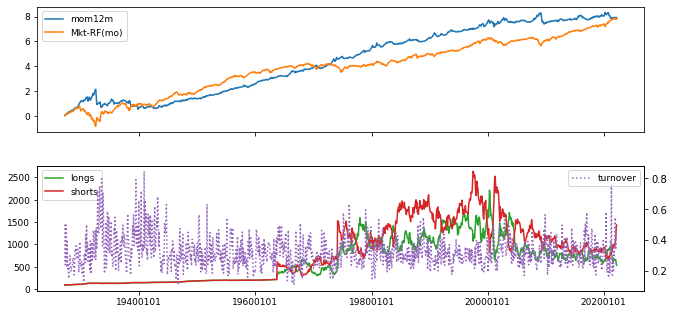

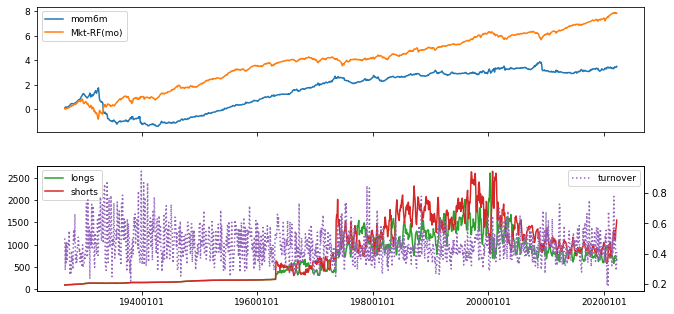

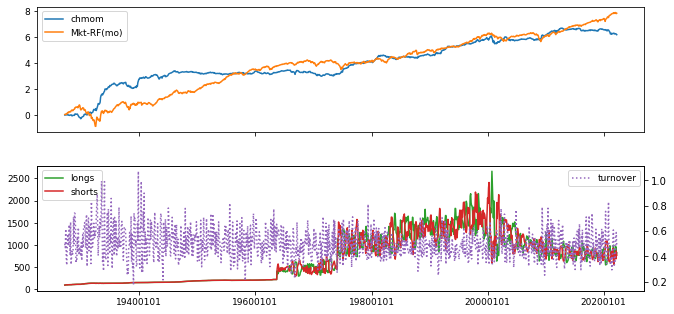

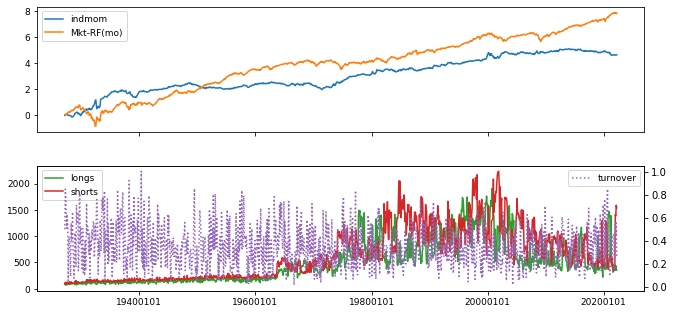

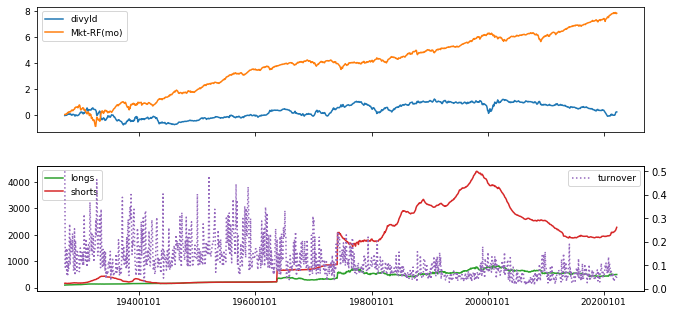

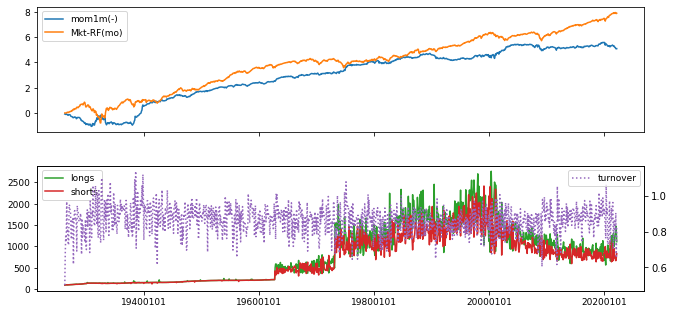

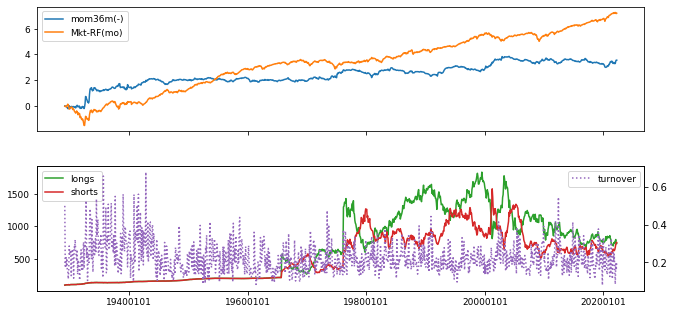

In [3]:
if 'monthly' in testable:
    if regenerate:
        beg, end = 19251231, LAST_DATE
        intervals = {'mom12m': (2,12),
                     'mom36m': (13,36),
                     'mom6m': (2,6),
                     'mom1m': (1,1)}
        for label, past in intervals.items():
            out = []
            rebaldates = bd.date_range(bd.endmo(beg, past[1]), end, 'endmo')
            for rebaldate in rebaldates:
                start = bd.endmo(rebaldate, -past[1])
                beg1 = bd.offset(start, 1)
                end1 = bd.endmo(rebaldate, 1-past[0])
                df = crsp.get_universe(end1)
                df['start'] = crsp.get_section(dataset='monthly',
                                               fields=['ret'],
                                               date_field='date',
                                               date=start).reindex(df.index)
                df[label] = crsp.get_ret(beg1, end1).reindex(df.index)
                df['permno'] = df.index
                df['rebaldate'] = rebaldate
                df = df.dropna(subset=['start'])
                out.append(df[['rebaldate', 'permno', label]]) # append rows
            out = pd.concat(out, axis=0, ignore_index=True)
            n = signals.write(out, label, overwrite=True)

        beg, end = 19270101, LAST_DATE
        columns = ['chmom', 'divyld', 'indmom']
        out = []
        for rebaldate in bd.date_range(beg, end, 'endmo'):
            start = bd.endmo(rebaldate, -12)
            beg1 = bd.offset(start, 1)
            end1 = bd.endmo(rebaldate, -6)
            beg2 = bd.offset(end1, 1)
            end2 = bd.endmo(rebaldate)
            df = crsp.get_universe(end1)
            df['start'] = crsp.get_section(dataset='monthly',
                                           fields=['ret'],
                                           date_field='date',
                                           date=start).reindex(df.index)
            df['end2'] = crsp.get_section(dataset='monthly',
                                          fields=['ret'],
                                          date_field='date',
                                          date=end2).reindex(df.index)
            df['mom2'] = crsp.get_ret(beg2, end2).reindex(df.index)
            df['mom1'] = crsp.get_ret(beg1, end1).reindex(df.index)
            df['divyld'] = crsp.get_divamt(beg1, end2)\
                               .reindex(df.index)['divamt']\
                               .div(df['cap'])\
                               .fillna(0)
            df['chmom'] = df['mom1'] - df['mom2']

            # 6-month two-digit sic industry momentum (group means of 'mom1')
            df['sic2'] = df['siccd'] // 100
            df = df.join(DataFrame(df.groupby(['sic2'])['mom1'].mean())\
                         .rename(columns={'mom1': 'indmom'}),
                         on='sic2', how='left')
            df['permno'] = df.index
            df['rebaldate'] = rebaldate
            out.append(df.dropna(subset=['start','end2'])\
                       [['rebaldate', 'permno'] + columns])
        out = pd.concat(out, axis=0, ignore_index=True)
        for label in columns:   # save signal values to sql
            n = signals.write(out, label, overwrite=True)

    benchnames = ['Mkt-RF(mo)']
    rebalbeg, rebalend = 19260101, LAST_DATE
    for num, label in enumerate(['mom12m', 'mom6m', 'chmom', 'indmom',
                                 'divyld', 'mom1m', 'mom36m']):
        holdings = portfolio_sorts(crsp,
                                   label,
                                   SignalsFrame(signals.read(label)),
                                   rebalbeg,
                                   rebalend,
                                   window=1,
                                   months=[],
                                   leverage=leverage.get(label, 1))
        excess = backtest_pipeline(backtest,
                                   crsp,
                                   holdings,
                                   label,
                                   benchnames,
                                   overlap=0,
                                   outdir=outdir,
                                   suffix=(leverage.get(label, 1) < 0)*'(-)')

## Weekly returns-based price response signals        

Last FamaFrench Date 2022-11-30 00:00:00


beta: 100%|█████████████████████████████████████████████████| 1114/1114 [00:21<00:00, 52.19it/s]


      excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs  shorts   buys  sells
beta   0.021   0.086 -0.057      -0.36    -0.41    0.682     0.963  718.795  771.05  0.952  0.974


idiovol: 100%|██████████████████████████████████████████████| 1114/1114 [00:21<00:00, 52.49it/s]


            excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs    shorts   buys  sells
idiovol(-)  -0.008  -0.038  0.036      0.201   -0.397    0.692       0.7  375.828  1309.562  0.708  0.691


pricedelay: 100%|███████████████████████████████████████████| 1114/1114 [00:20<00:00, 55.04it/s]


               excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
pricedelay(-)   0.018   0.217  0.011      0.142   -0.026    0.979     4.179  703.507  662.913  4.174  4.184


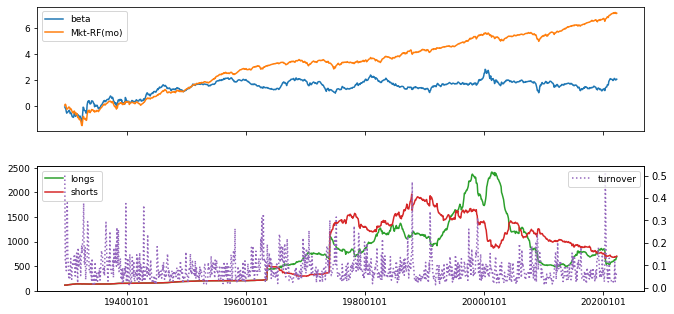

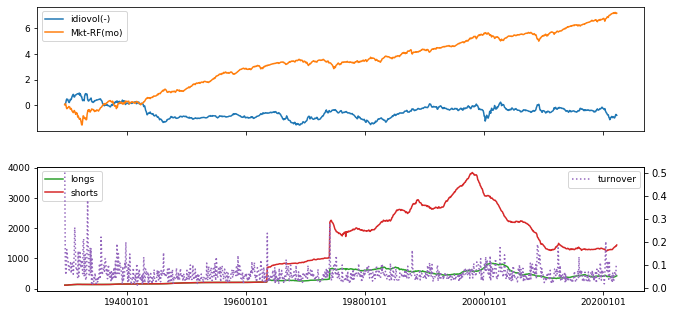

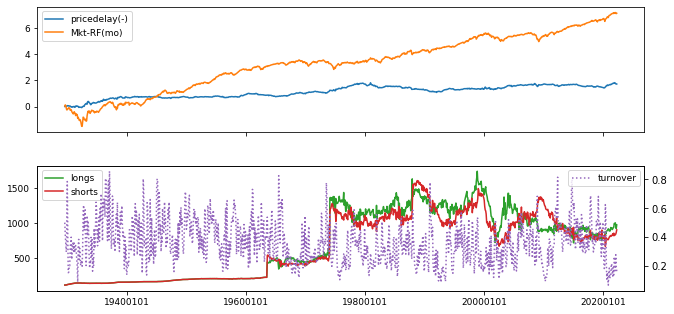

In [4]:
# helper to calculate beta, idiovol and price delay from weekly returns
def regress(x: np.array, y: np.array) -> Tuple[float, float, float]:
    """helper method to calculate beta, idiovol and price delay

    Args:
      x: equal-weighted market returns (in ascending time order)
      y: stock returns (in ascending time order).  NaN's will be discarded.

    Returns:
      beta: slope from regression on market returns and intercept
      idiovol: mean squared error of residuals
      pricedelay: increase of adjusted Rsq with four market lags over without
    """
    v = np.logical_not(np.isnan(y))
    y = y[v]
    x = x[v]
    n0 = len(y)
    A0 = np.vstack([x, np.ones(len(y))]).T
    b0 = np.linalg.inv(A0.T.dot(A0)).dot(A0.T.dot(y))   # univariate coeffs
    sse0 = np.mean((y - A0.dot(b0))**2)
    sst0 = np.mean((y - np.mean(y))**2)
    if (sst0>0 and sse0>0):
        R0 = (1 - ((sse0 / (n0 - 2)) / (sst0 / (n0 - 1))))
    else:
        R0 = 0
    y4 = y[4:]
    n4 = len(y4)         
    A4 = np.vstack([x[0:-4], x[1:-3], x[2:-2], x[3:-1], x[4:],
                    np.ones(n4)]).T
    b4 = np.linalg.inv(A4.T.dot(A4)).dot(A4.T.dot(y4))  # four lagged coeffs
    sse4 = np.mean((y4 - A4.dot(b4))**2)
    sst4 = np.mean((y4 - np.mean(y4))**2)
    if sst4 > 0 and sse4 > 0:
        R4 = (1 - ((sse4 / (n4 - 6)) / (sst4 / (n4 - 1))))
    else:
        R4 = 0    
    return [b0[0],
            sse0 or np.nan,
            (1 -(R0 / R4)) if R0>0 and R4>0 else np.nan]

if 'weekly' in testable:    
    beg, end = 19260101, LAST_DATE
    columns  = ['beta', 'idiovol', 'pricedelay']
    wd = WeeklyDay(sql, 'Wed', beg, end)  # custom weekly trading day calendar
        
    width    = 3*52+1           # up to 3 years of weekly returns
    minvalid = 52               # at least 52 weeks required to compute beta
    weekly   = DataFrame()      # rolling window of weekly stock returns
    mkt      = DataFrame()      # to queue equal-weighted market returns
    out      = []               # to accumulate final calculations

    if regenerate:

        """
        # Pre-generate weekly returns and save in cache-store
        batchsize = 40
        r = wd.date_tuples(wd.date_range(beg, LAST_DATE))
        batches = [r[i:(i+batchsize)] for i in range(0, len(r), batchsize)]
        for batch in batches:
            crsp.cache_ret(batch, replace=True)
        """
        
        for date in wd.date_range(beg, end):
            df = crsp.get_ret(wd.begwk(date), date)
            mkt = as_rolling(mkt,       # rolling window of weekly mkt returns
                             DataFrame(data=[df.mean()], columns=[date]),
                             width=width)
            weekly = as_rolling(weekly, # rolling window of weekly stock returns
                                df.rename(date),
                                width=width) 
            valid = weekly.count(axis=1) >= minvalid  # require min number weeks
            if valid.any():
                result = DataFrame([regress(mkt.values[0], y)
                                    for y in weekly.loc[valid].values],
                                   columns=columns)
                result['permno'] = weekly.index[valid].values
                result['rebaldate'] = date
                if wd.ismonthend(date): # signal value from last week of month
                    out.append(result)
        out = pd.concat(out, axis=0, ignore_index=True)
        for label in columns:
            signals.write(out, label, overwrite=True)

    benchnames = ['Mkt-RF(mo)']
    rebalbeg, rebalend = 19290601, LAST_DATE
    for num, label in enumerate(columns):
        holdings = portfolio_sorts(crsp,
                                   label,
                                   SignalsFrame(signals.read(label)),
                                   rebalbeg,
                                   rebalend,
                                   window=1,
                                   months=[],
                                   leverage=leverage.get(label, 1))
        excess = backtest_pipeline(backtest,
                                   crsp,
                                   holdings,
                                   label,
                                   benchnames,
                                   overlap=0,
                                   outdir=outdir,
                                   suffix=(leverage.get(label, 1) < 0)*'(-)')

## Liquidity signals from daily stock returns

ill: 100%|████████████████████████████████████████████████████| 466/466 [00:08<00:00, 54.34it/s]


        excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs    shorts   buys  sells
ill(-)   0.032   0.251  0.047      0.381    -1.56    0.119      1.84  395.688  1987.391  1.835  1.845


maxret: 100%|█████████████████████████████████████████████████| 466/466 [00:08<00:00, 52.00it/s]


           excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs    shorts   buys  sells
maxret(-)    0.04   0.212  0.101      0.667   -0.727    0.468     7.585  702.129  2113.591  7.579   7.59


retvol: 100%|█████████████████████████████████████████████████| 466/466 [00:09<00:00, 49.59it/s]


           excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs    shorts   buys  sells
retvol(-)   0.043   0.196  0.118      0.663     -0.6    0.549     6.071  658.798  2301.587  6.066  6.077


baspread: 100%|███████████████████████████████████████████████| 466/466 [00:09<00:00, 49.94it/s]


          excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover     longs   shorts   buys  sells
baspread  -0.012  -0.049 -0.094     -0.512     0.34    0.734       4.2  2641.095  580.376  4.197  4.203


std_dolvol: 100%|█████████████████████████████████████████████| 466/466 [00:09<00:00, 49.44it/s]


            excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover     longs   shorts   buys  sells
std_dolvol  -0.013  -0.136 -0.012     -0.121    0.893    0.372     5.753  2553.976  425.966  5.754  5.753


zerotrade: 100%|██████████████████████████████████████████████| 466/466 [00:08<00:00, 52.55it/s]


              excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover     longs    shorts   buys  sells
zerotrade(-)   0.025   0.147 -0.033     -0.239    0.159    0.874     3.915  1101.787  2172.596  3.906  3.924


std_turn: 100%|███████████████████████████████████████████████| 466/466 [00:10<00:00, 46.48it/s]


          excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover     longs    shorts   buys  sells
std_turn   0.004   0.025 -0.047     -0.328    0.583     0.56     5.476  1446.658  1209.505  5.472  5.481


turn: 100%|███████████████████████████████████████████████████| 466/466 [00:09<00:00, 49.95it/s]


      excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover     longs    shorts   buys  sells
turn   0.013   0.071 -0.049      -0.35    0.463    0.644     1.832  1176.245  1734.991  1.826  1.839


dolvol: 100%|█████████████████████████████████████████████████| 466/466 [00:08<00:00, 51.84it/s]


        excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs    shorts   buys  sells
dolvol   0.011   0.099  0.005      0.048   -1.504    0.133     1.362  401.482  2802.452  1.362  1.362


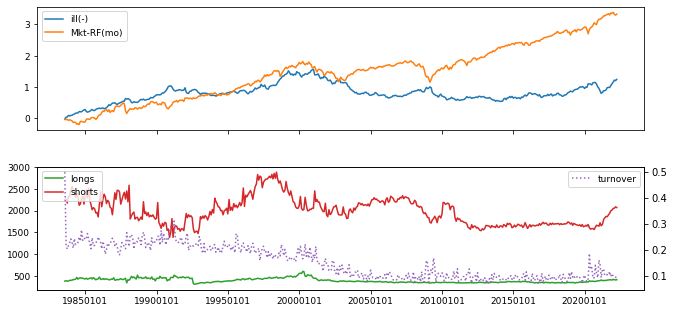

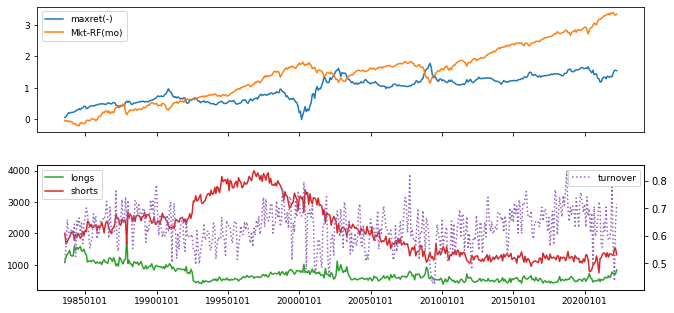

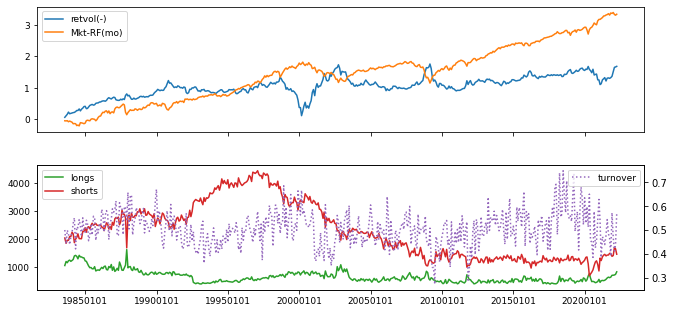

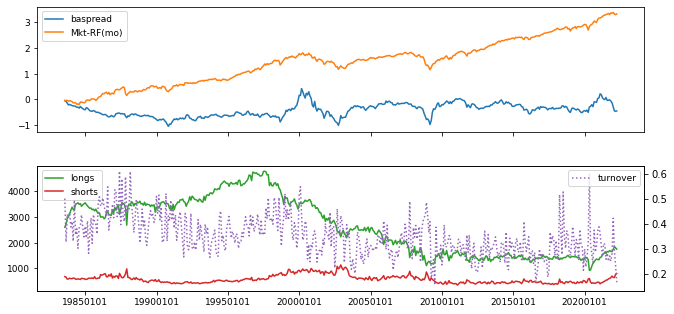

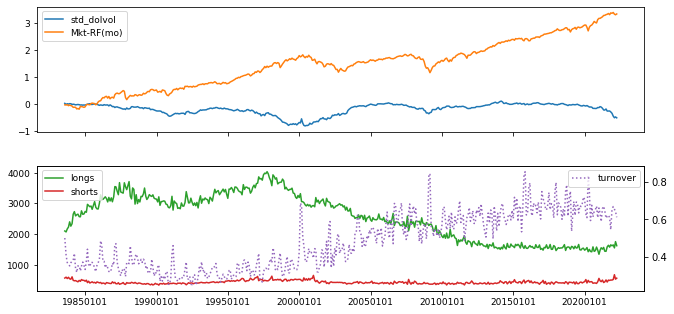

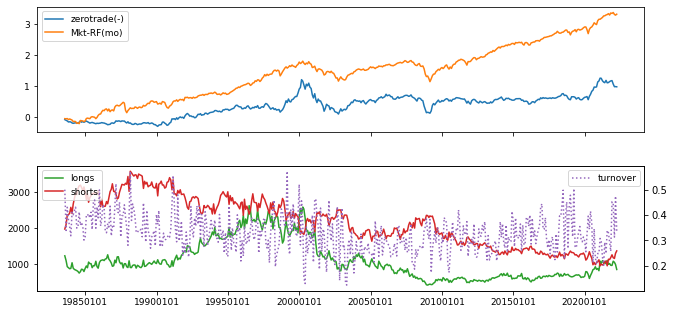

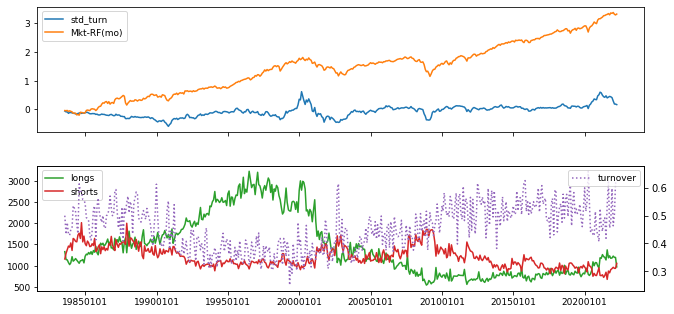

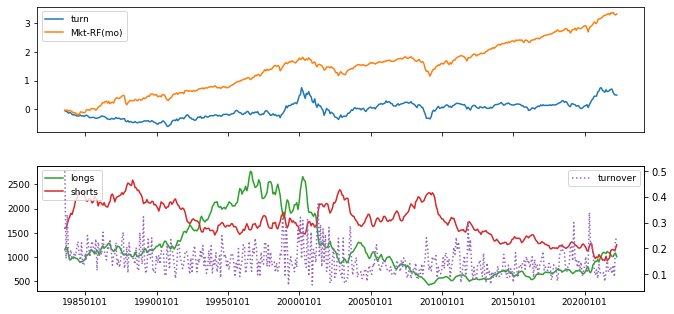

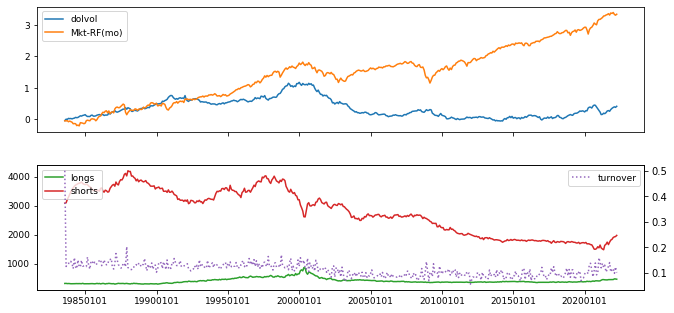

In [34]:
if 'daily' in testable:
    beg, end = 19830601, LAST_DATE    # nasdaq/volume from after 1982
    columns = ['ill', 'maxret', 'retvol', 'baspread', 'std_dolvol',
               'zerotrade', 'std_turn', 'turn']
    if regenerate:
        out = []
        dolvol = []
        turn = DataFrame()    # to average turn signal over rolling 3-months
        dt = bd.date_range(bd.begmo(beg,-3), end, 'endmo') # monthly rebalances
        chunksize = 12        # each chunk is 12 months (1 year)
        chunks = [dt[i:(i+chunksize)] for i in range(0, len(dt), chunksize)]
        for chunk in tqdm(chunks):
            q = (f"SELECT permno, date, ret, askhi, bidlo, prc, vol, shrout "
                 f" FROM {crsp['daily'].key}"
                 f" WHERE date>={bd.begmo(chunk[0])}"
                 f"   AND date<={chunk[-1]}")        # retrieve a chunk
            f = crsp.sql.read_dataframe(q).sort_values(['permno', 'date'])
            f['baspread'] = ((f['askhi'] - f['bidlo']) /
                             ((f['askhi'] + f['bidlo']) / 2))
            f['dolvol'] = f['prc'].abs() * f['vol']
            f['turn1'] = f['vol'] / f['shrout']
            f.loc[f['dolvol']>0, 'ldv'] = np.log(f.loc[f['dolvol']>0, 'dolvol'])
            f['ill'] = 1000000 * f['ret'].abs() / f['dolvol']

            for rebaldate in chunk:            # for each rebaldate in the chunk
                grouped = f[f['date'].ge(bd.begmo(rebaldate))
                            & f['date'].le(rebaldate)].groupby('permno')
                df = grouped[['ret']].max().rename(columns={'ret': 'maxret'})
                df['retvol'] = grouped['ret'].std()
                df['baspread'] = grouped['baspread'].mean()
                df['std_dolvol'] = grouped['ldv'].std()
                df['ill'] = grouped['ill'].mean()
                dv = grouped['dolvol'].sum()
                df.loc[dv > 0, 'dolvol'] = np.log(dv[dv > 0])
                df['turn1'] = grouped['turn1'].sum()
                df['std_turn'] = grouped['turn1'].std()
                df['countzero'] = grouped['vol'].apply(lambda v: sum(v==0))
                df['ndays'] = grouped['prc'].count()
            
                turn = as_rolling(turn, df[['turn1']], width=3)
                df['turn'] = turn.reindex(df.index).mean(axis=1, skipna=False)
                df.loc[df['turn1'].le(0), 'turn1'] = 0
                df.loc[df['ndays'].le(0), 'ndays'] = 0
                df['zerotrade'] = ((df['countzero'] + ((1/df['turn1'])/480000))
                                   * 21/df['ndays'])
    
                df['rebaldate'] = rebaldate
                df = df.reset_index()
                out.append(df[['permno', 'rebaldate'] + columns])
                if rebaldate < bd.endmo(end):
                    df['rebaldate'] = bd.endmo(rebaldate, 1)
                    dolvol.append(df[['permno','rebaldate','dolvol']])
        out = pd.concat(out, axis=0, ignore_index=True)
        dolvol = pd.concat(dolvol, axis=0, ignore_index=True)            

        for label in columns:
            n = signals.write(out, label, overwrite=True)
        n = signals.write(dolvol, 'dolvol', overwrite=True)

    rebalbeg, rebalend = 19830601, LAST_DATE
    benchnames = ['Mkt-RF(mo)']
    for num, label in enumerate(columns + ['dolvol']):
        holdings = portfolio_sorts(crsp,
                                   label,
                                   SignalsFrame(signals.read(label)),
                                   rebalbeg,
                                   rebalend,
                                   window=1,
                                   months=[],
                                   leverage=leverage.get(label, 1))
        excess = backtest_pipeline(backtest,
                                   crsp,
                                   holdings,
                                   label,
                                   benchnames,
                                   overlap=0,
                                   outdir=outdir,
                                   suffix=(leverage.get(label, 1) < 0)*'(-)')

## Fundamental signals from Compustat Annual

absacc: 100%|████████████████████████████████████████████████| 627/627 [00:03<00:00, 194.28it/s]


           excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs    shorts   buys  sells
absacc(-)   0.009   0.082   0.02      0.185   -2.285    0.023     0.825  711.251  1111.473  0.825  0.824


acc: 100%|███████████████████████████████████████████████████| 627/627 [00:03<00:00, 196.63it/s]


        excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
acc(-)   0.038     0.4  0.038      0.405    0.468     0.64     0.832  954.767  974.679  0.823   0.84


agr: 100%|███████████████████████████████████████████████████| 627/627 [00:03<00:00, 188.99it/s]


        excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs    shorts   buys  sells
agr(-)   0.036   0.369  0.049      0.538    -1.47    0.142     0.919  998.682  1000.936  0.913  0.925


bm: 100%|████████████████████████████████████████████████████| 627/627 [00:03<00:00, 194.79it/s]


    excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover     longs    shorts   buys  sells
bm   0.038   0.289  0.036      0.271   -1.788    0.074     0.548  1043.281  1042.139  0.542  0.555


cashpr: 100%|████████████████████████████████████████████████| 627/627 [00:03<00:00, 195.36it/s]


           excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
cashpr(-)   0.028   0.272  0.035      0.338   -1.693    0.091      0.51  794.113  819.121  0.509  0.512


cfp: 100%|███████████████████████████████████████████████████| 627/627 [00:03<00:00, 196.56it/s]


     excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs    shorts   buys  sells
cfp   0.029    0.24  0.042      0.366   -0.254      0.8     0.811  632.866  1428.117  0.807  0.815


chcsho: 100%|████████████████████████████████████████████████| 627/627 [00:03<00:00, 196.02it/s]


           excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
chcsho(-)   0.042   0.509  0.058      0.768    -1.48    0.139     0.852  842.581  965.911  0.843  0.861


chinv: 100%|█████████████████████████████████████████████████| 627/627 [00:03<00:00, 197.88it/s]


          excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
chinv(-)    0.04   0.482  0.052      0.648   -1.114    0.266     0.932  811.129  866.029  0.924  0.939


depr: 100%|██████████████████████████████████████████████████| 627/627 [00:03<00:00, 199.82it/s]


      excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover     longs   shorts  buys  sells
depr   0.013   0.116 -0.013     -0.127    0.287    0.774     0.408  1378.717  620.882   0.4  0.416


dy: 100%|████████████████████████████████████████████████████| 627/627 [00:04<00:00, 152.05it/s]


    excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs    shorts   buys  sells
dy   0.009   0.053  0.048      0.344   -1.327    0.185     0.474  540.665  2239.065  0.484  0.465


egr: 100%|███████████████████████████████████████████████████| 627/627 [00:03<00:00, 197.70it/s]


        excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs  shorts   buys  sells
egr(-)   0.032    0.36  0.046      0.537   -0.624    0.533     0.869  995.671  914.84  0.864  0.874


ep: 100%|████████████████████████████████████████████████████| 627/627 [00:03<00:00, 194.19it/s]


    excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs    shorts   buys  sells
ep   0.045    0.32  0.065      0.494   -2.164    0.031     0.761  745.345  1511.002  0.755  0.766


gma: 100%|███████████████████████████████████████████████████| 627/627 [00:03<00:00, 197.42it/s]


     excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
gma   0.012   0.102  0.011      0.098    1.232    0.219      0.38  969.169  984.059  0.373  0.387


grcapx: 100%|████████████████████████████████████████████████| 627/627 [00:03<00:00, 201.19it/s]


        excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
grcapx   -0.02  -0.238 -0.027      -0.33    1.521    0.129     0.902  868.883  889.847  0.905  0.899


grltnoa: 100%|███████████████████████████████████████████████| 627/627 [00:03<00:00, 198.52it/s]


         excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover     longs   shorts   buys  sells
grltnoa   0.022   0.261  0.024      0.285    0.557    0.578     0.968  1129.546  605.064  0.963  0.973


hire: 100%|██████████████████████████████████████████████████| 627/627 [00:03<00:00, 196.77it/s]


      excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover     longs   shorts   buys  sells
hire  -0.007  -0.075 -0.022      -0.25     1.33    0.184     0.901  1085.767  888.355  0.899  0.902


invest: 100%|████████████████████████████████████████████████| 627/627 [00:03<00:00, 194.54it/s]


           excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
invest(-)   0.025   0.276  0.033      0.374   -2.451    0.015     0.871  866.169  838.165  0.868  0.875


lev: 100%|███████████████████████████████████████████████████| 627/627 [00:03<00:00, 197.46it/s]


     excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs    shorts   buys  sells
lev   0.011   0.079  0.008      0.056   -1.616    0.107      0.41  902.184  1398.008  0.411  0.409


lgr: 100%|███████████████████████████████████████████████████| 627/627 [00:03<00:00, 204.46it/s]


     excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover     longs   shorts   buys  sells
lgr  -0.006  -0.081 -0.017     -0.226    1.546    0.123     0.996  1041.636  963.339  0.996  0.996


pchdepr: 100%|███████████████████████████████████████████████| 627/627 [00:03<00:00, 195.61it/s]


         excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover     longs   shorts   buys  sells
pchdepr    0.01   0.143   0.01      0.146   -2.349    0.019      1.05  1076.639  929.286  1.048  1.053


pchgm_pchsale: 100%|█████████████████████████████████████████| 627/627 [00:03<00:00, 199.11it/s]
/home/terence/Dropbox/github/financial-data-science/finds/backtesting.py:790: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, clear=True,


               excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover   longs   shorts  buys  sells
pchgm_pchsale   0.012   0.154  0.009      0.125    0.716    0.474     0.983  897.95  964.703  0.98  0.986


pchquick: 100%|██████████████████████████████████████████████| 627/627 [00:03<00:00, 197.90it/s]


          excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
pchquick   0.002   0.033  0.002       0.04   -0.061    0.951     1.088  798.062  899.722  1.088  1.088


pchsale_pchinvt: 100%|███████████████████████████████████████| 627/627 [00:03<00:00, 201.10it/s]


                 excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
pchsale_pchinvt   0.028   0.419  0.029      0.437   -1.271    0.204     1.015  841.748  791.045  1.008  1.022


pchsale_pchrect: 100%|███████████████████████████████████████| 627/627 [00:03<00:00, 197.92it/s]


                 excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
pchsale_pchrect   0.002   0.035  0.002      0.026   -3.796      0.0     1.067  943.262  921.498  1.067  1.068


pchsale_pchxsga: 100%|███████████████████████████████████████| 627/627 [00:03<00:00, 191.39it/s]


                 excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
pchsale_pchxsga  -0.004  -0.054 -0.003     -0.042   -1.777    0.076       1.0  845.797  837.497  1.001  0.999


pchsaleinv: 100%|████████████████████████████████████████████| 627/627 [00:03<00:00, 198.24it/s]


            excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
pchsaleinv   0.034   0.496  0.035      0.512   -1.449    0.148     1.016  816.002  817.393  1.008  1.024


pctacc: 100%|████████████████████████████████████████████████| 627/627 [00:03<00:00, 187.85it/s]


           excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs    shorts   buys  sells
pctacc(-)   0.013   0.156  0.019      0.223    1.257    0.209     0.909  718.131  1025.141  0.907  0.912


quick: 100%|█████████████████████████████████████████████████| 627/627 [00:03<00:00, 195.46it/s]


       excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover     longs   shorts   buys  sells
quick   0.007   0.051 -0.021     -0.171    0.328    0.743     0.482  1307.518  607.601  0.475  0.489


rd_sale: 100%|███████████████████████████████████████████████| 627/627 [00:02<00:00, 209.42it/s]


         excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover   longs   shorts   buys  sells
rd_sale  -0.007   -0.05 -0.014       -0.1    0.579    0.563     0.362  848.92  424.573  0.364  0.361


rd_mve: 100%|████████████████████████████████████████████████| 627/627 [00:02<00:00, 209.06it/s]


        excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
rd_mve   0.029   0.205  0.015      0.104   -0.205    0.837     0.474  691.599  433.161  0.468  0.481


realestate: 100%|████████████████████████████████████████████| 627/627 [00:03<00:00, 180.91it/s]


            excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
realestate   0.015   0.122  0.036      0.311   -0.908    0.364     0.499  428.336  744.094  0.495  0.503


salecash: 100%|██████████████████████████████████████████████| 627/627 [00:03<00:00, 193.08it/s]


          excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs    shorts   buys  sells
salecash  -0.008  -0.084  0.008       0.09   -0.105    0.917     0.514  683.826  1565.663  0.518   0.51


salerec: 100%|███████████████████████████████████████████████| 627/627 [00:03<00:00, 199.34it/s]


         excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs    shorts   buys  sells
salerec   0.027   0.296  0.042      0.497    1.213    0.226     0.406  741.032  1178.072  0.401  0.412


saleinv: 100%|███████████████████████████████████████████████| 627/627 [00:03<00:00, 199.24it/s]


         excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
saleinv   0.024   0.251  0.044      0.523    0.827    0.409     0.437  750.019  884.561  0.434  0.441


secured: 100%|███████████████████████████████████████████████| 627/627 [00:03<00:00, 181.23it/s]


            excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs    shorts   buys  sells
secured(-)   0.009   0.083   0.03      0.312     0.69     0.49     0.541  589.329  1216.714  0.542  0.541


sgr: 100%|███████████████████████████████████████████████████| 627/627 [00:03<00:00, 199.58it/s]


     excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover     longs   shorts   buys  sells
sgr  -0.012  -0.121 -0.026     -0.265   -0.088     0.93     0.902  1068.904  900.307  0.902  0.902


sp: 100%|████████████████████████████████████████████████████| 627/627 [00:03<00:00, 194.71it/s]


    excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
sp   0.045   0.375  0.039       0.33   -0.923    0.356     0.491  829.851  1307.35  0.481  0.501


tang: 100%|██████████████████████████████████████████████████| 627/627 [00:03<00:00, 196.30it/s]


      excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover     longs   shorts   buys  sells
tang   0.008   0.082 -0.005     -0.058    1.408     0.16     0.477  1560.388  630.947  0.473  0.481


bm_ia: 100%|█████████████████████████████████████████████████| 627/627 [00:03<00:00, 198.07it/s]


       excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover   longs   shorts   buys  sells
bm_ia   0.014   0.128  0.008      0.067   -1.816     0.07     0.791  918.74  781.543  0.789  0.794


cfp_ia: 100%|████████████████████████████████████████████████| 627/627 [00:03<00:00, 197.88it/s]


        excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover   longs   shorts   buys  sells
cfp_ia   -0.01  -0.103 -0.014     -0.145   -0.749    0.454     0.907  695.84  881.125  0.908  0.905


chatoia: 100%|███████████████████████████████████████████████| 627/627 [00:03<00:00, 200.92it/s]


         excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover  longs   shorts   buys  sells
chatoia   0.024   0.335  0.027      0.377   -1.934    0.054      0.99  875.3  822.072  0.984  0.995


chpmia: 100%|████████████████████████████████████████████████| 627/627 [00:03<00:00, 206.40it/s]


        excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
chpmia   0.014   0.137  0.015      0.148   -0.316    0.752     1.082  385.559  401.275  1.079  1.086


pchcapx_ia: 100%|████████████████████████████████████████████| 627/627 [00:03<00:00, 201.51it/s]


            excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
pchcapx_ia  -0.002  -0.025 -0.002     -0.026    0.163    0.871     1.115  382.875  391.061  1.115  1.115


chempia: 100%|███████████████████████████████████████████████| 627/627 [00:03<00:00, 198.00it/s]


         excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
chempia   0.001   0.015 -0.012     -0.148     1.25    0.212     0.979  807.006  782.768  0.976  0.981


mve_ia: 100%|████████████████████████████████████████████████| 627/627 [00:03<00:00, 196.93it/s]


           excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover     longs   shorts   buys  sells
mve_ia(-)   0.014   0.146  0.004      0.039   -0.407    0.684     0.379  1234.204  316.236  0.373  0.384


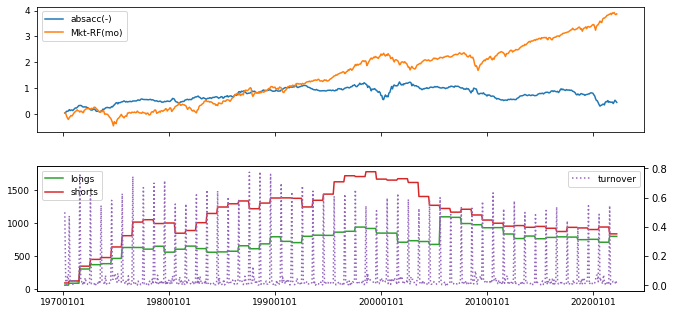

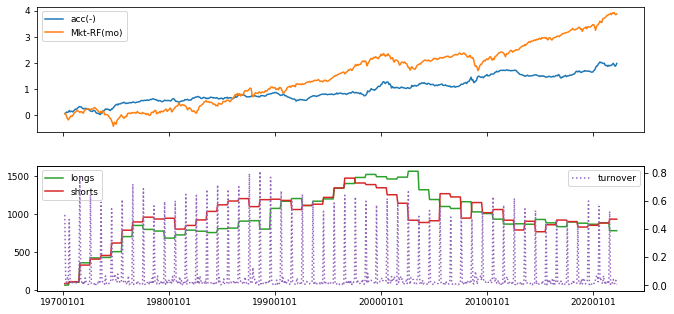

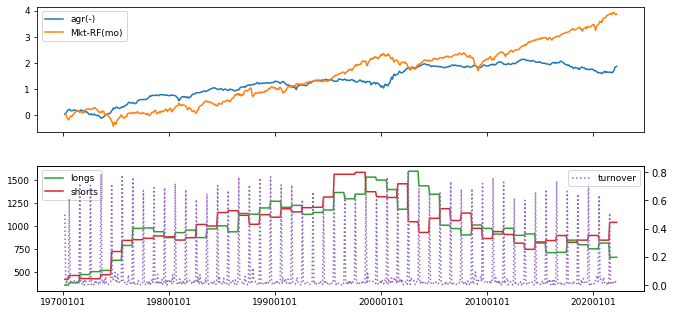

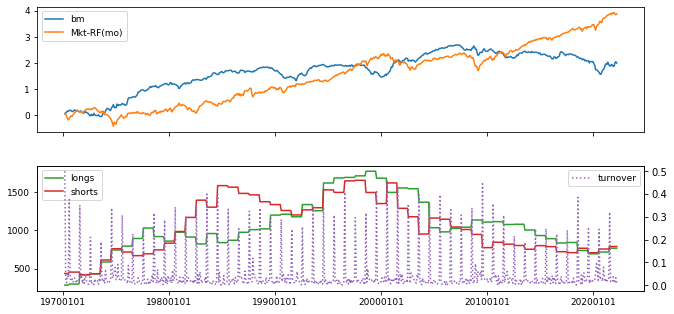

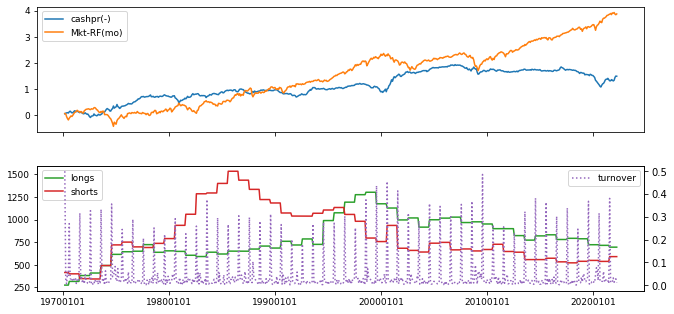

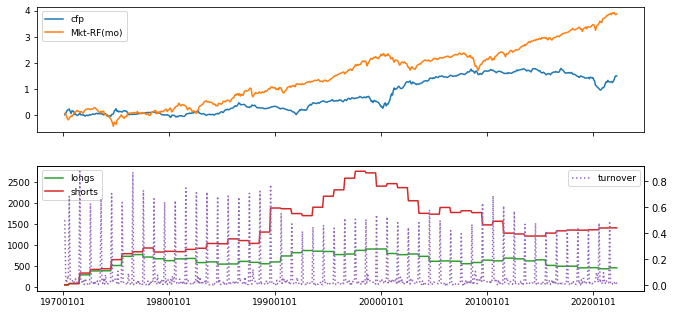

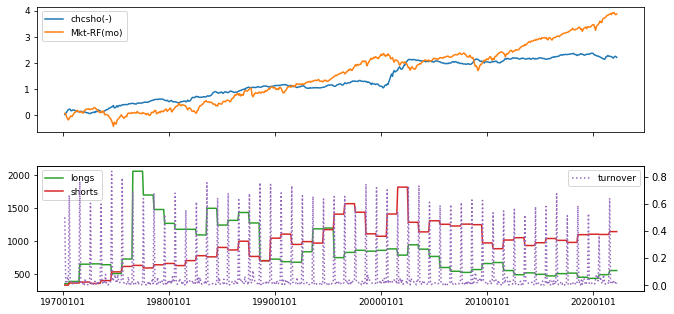

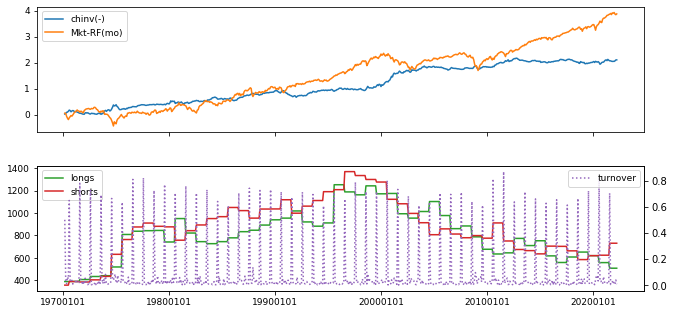

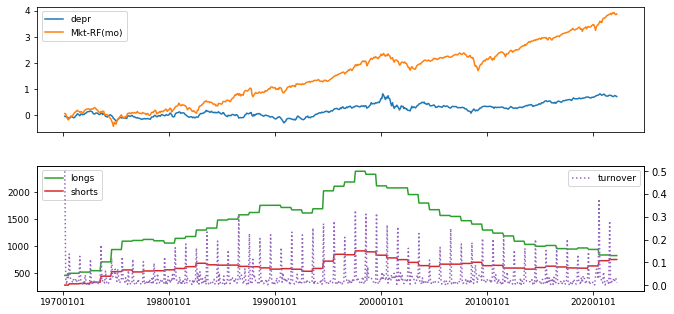

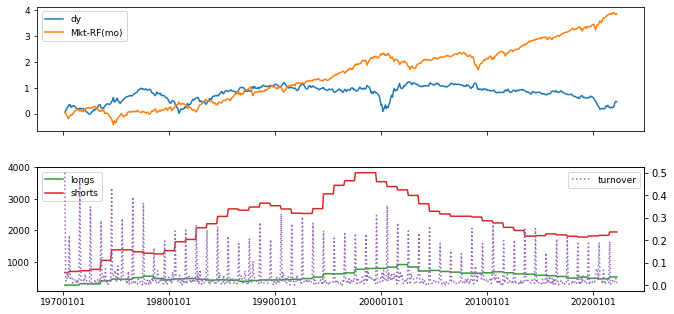

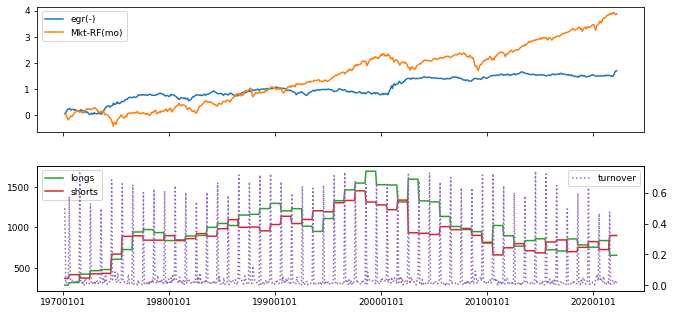

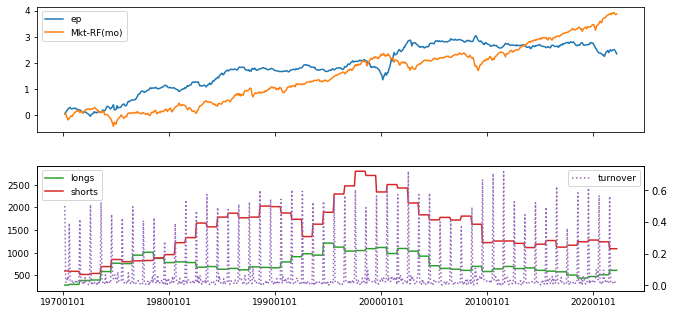

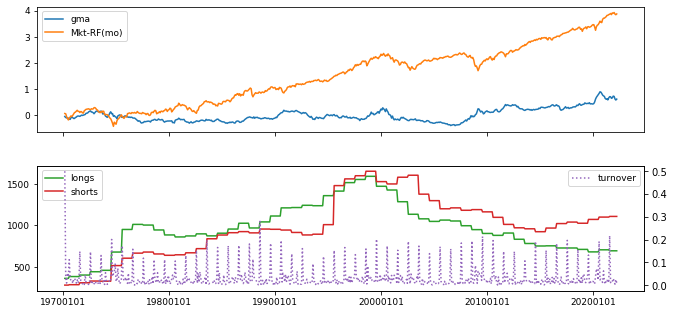

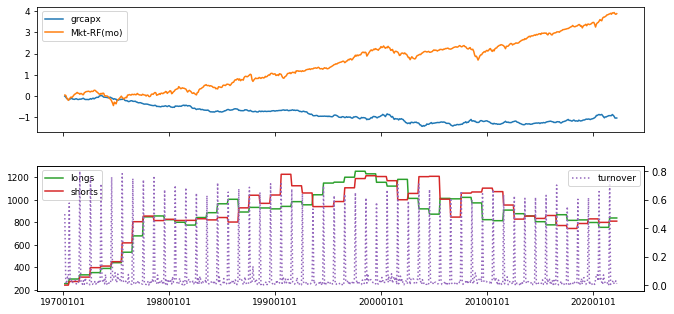

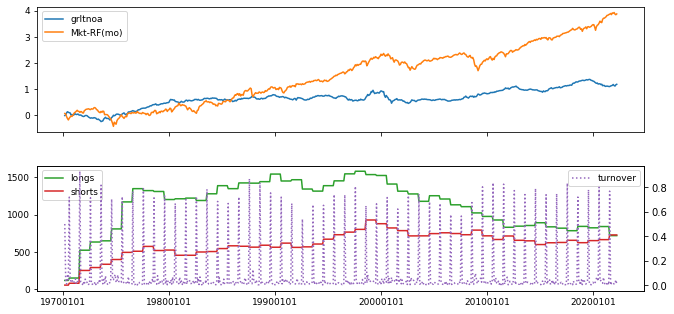

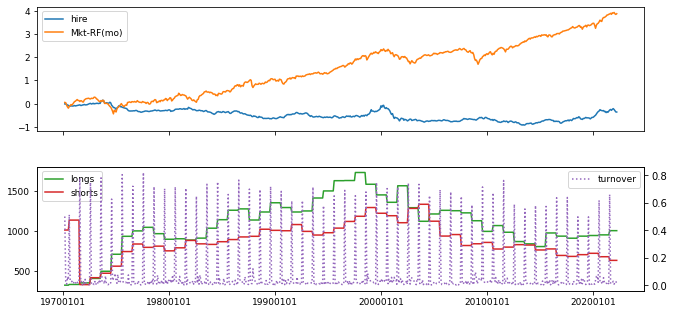

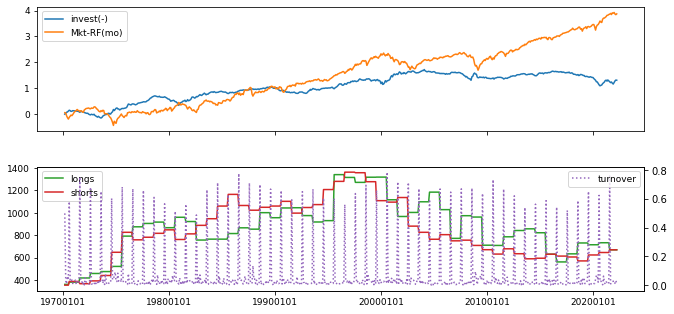

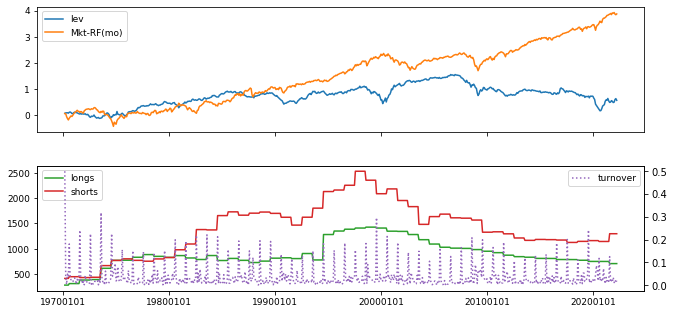

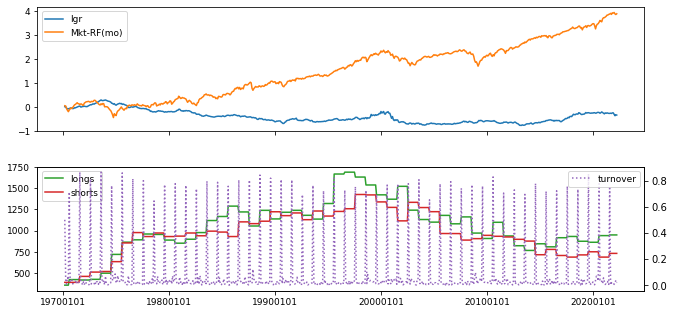

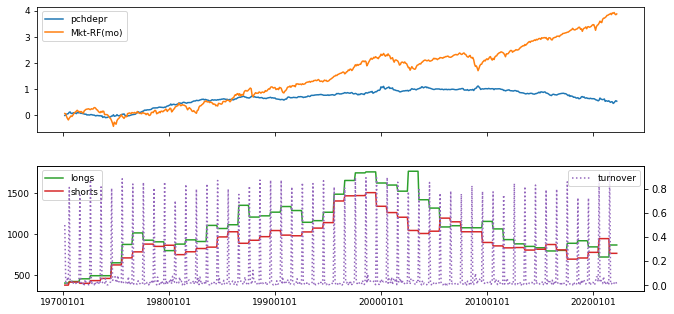

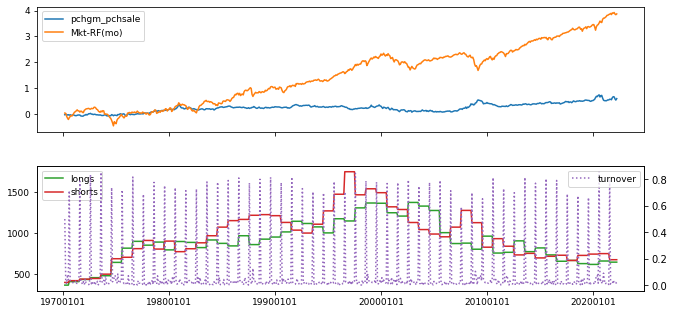

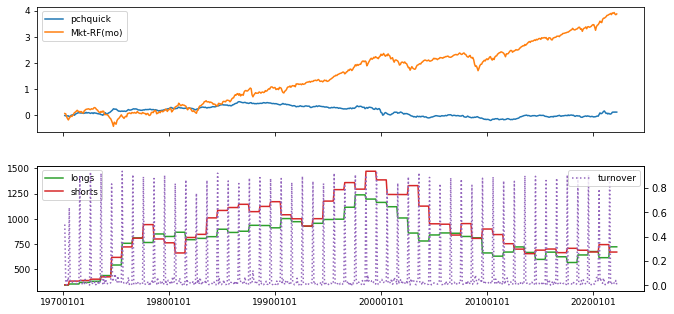

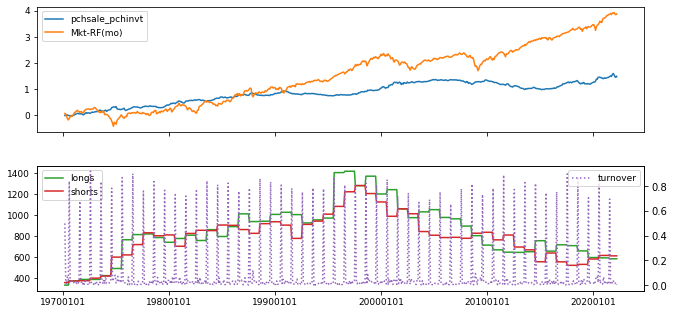

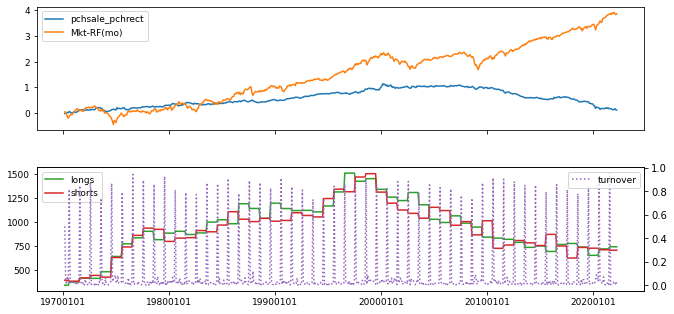

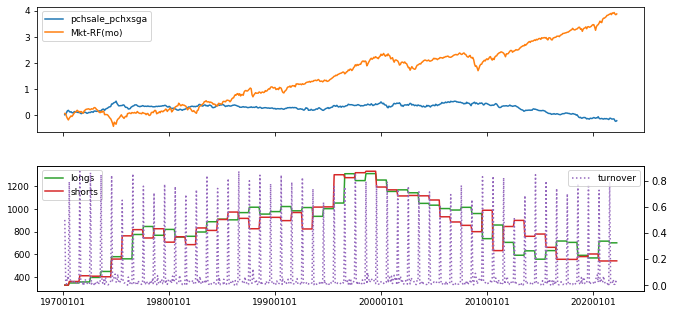

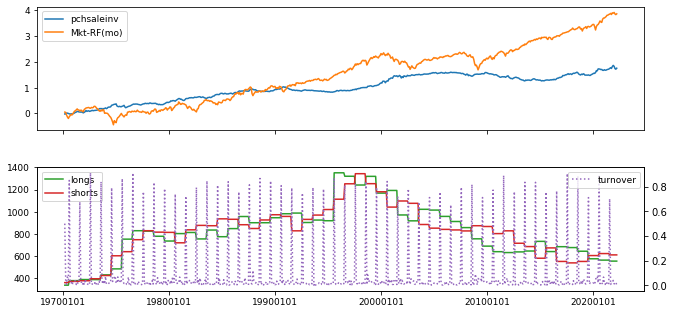

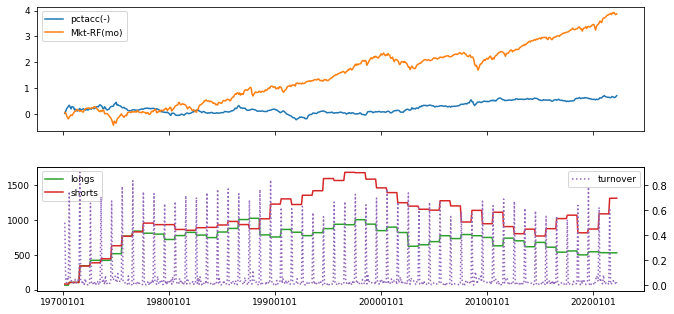

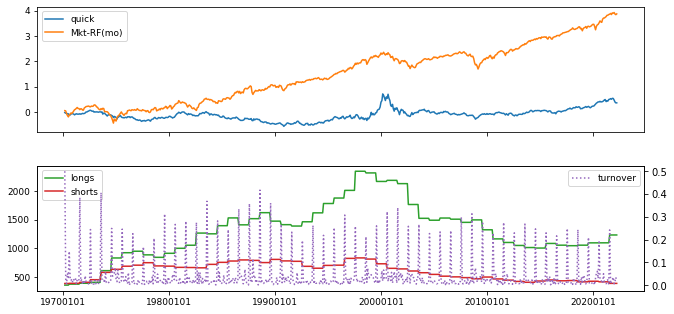

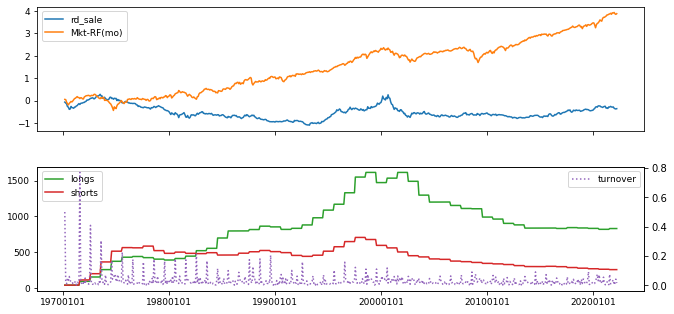

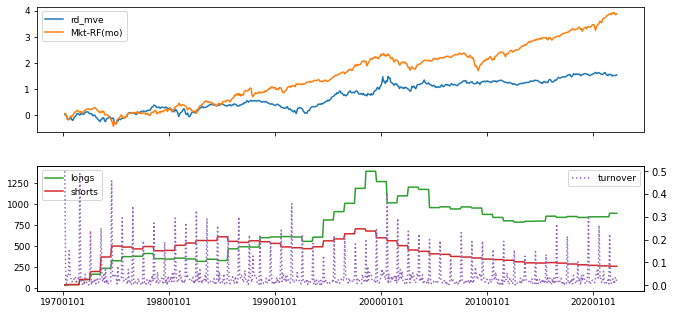

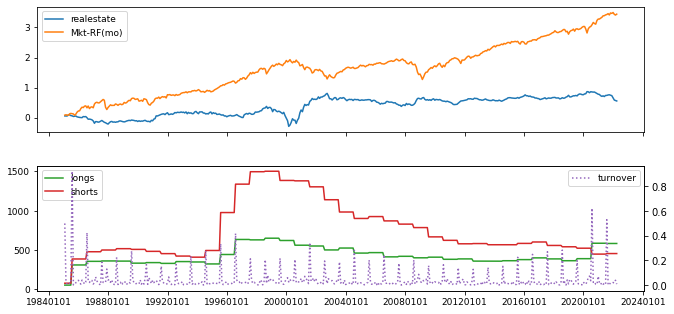

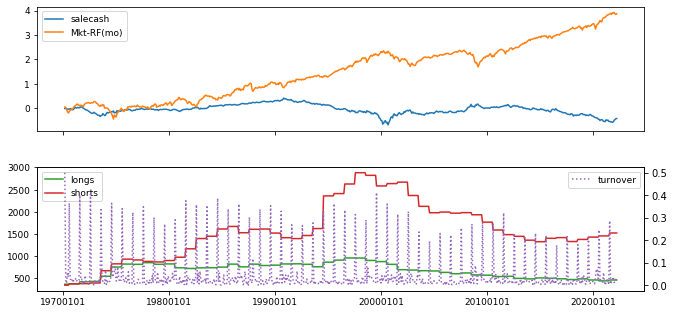

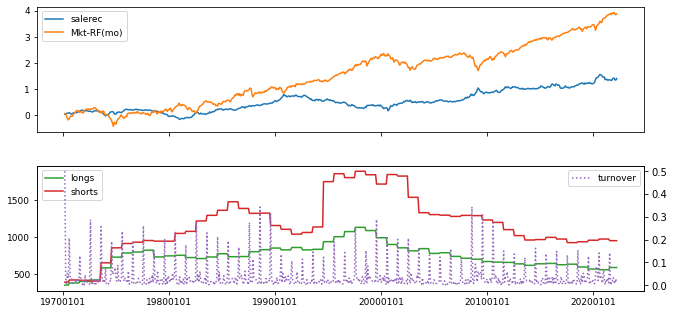

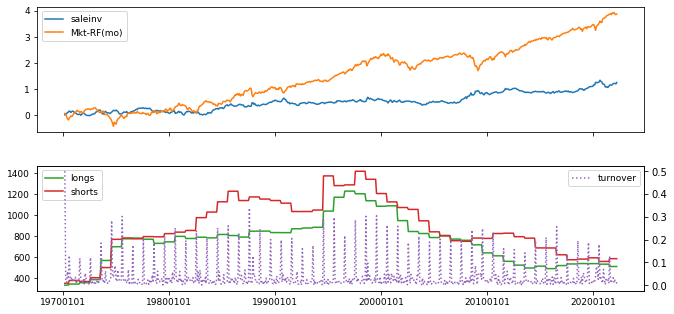

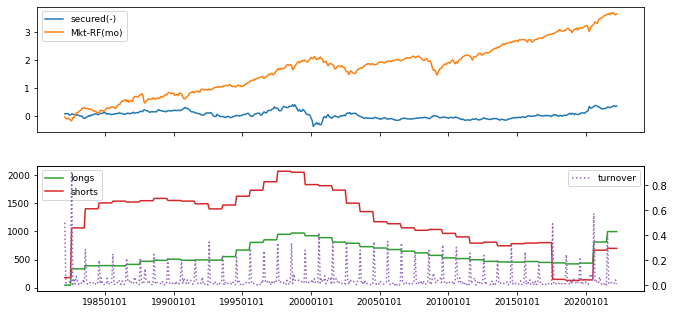

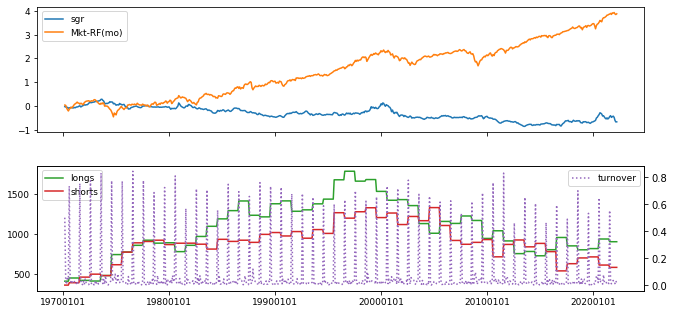

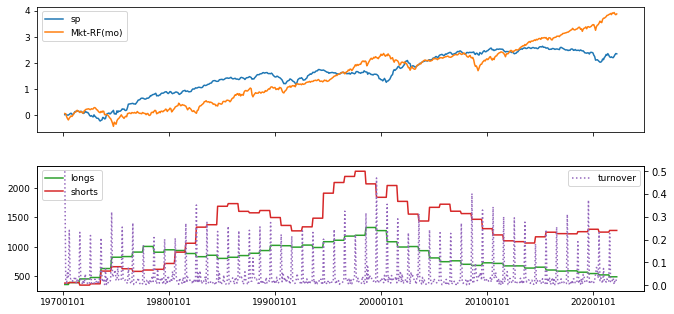

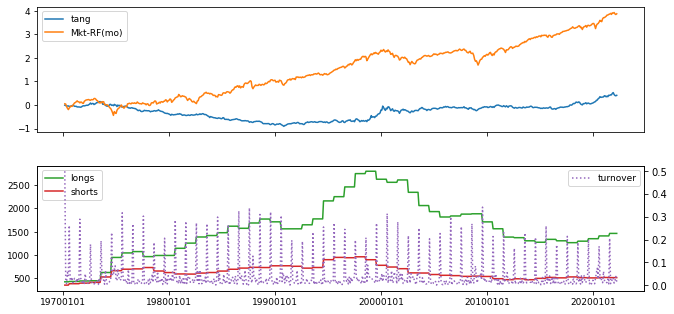

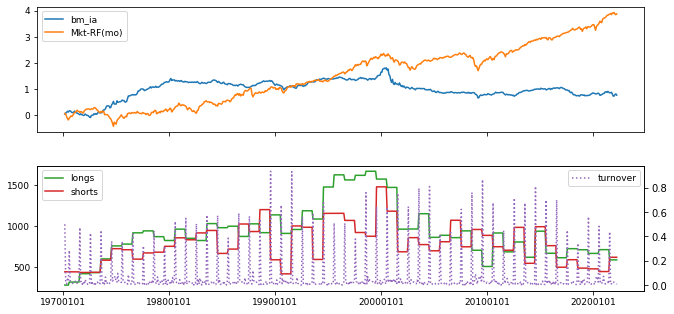

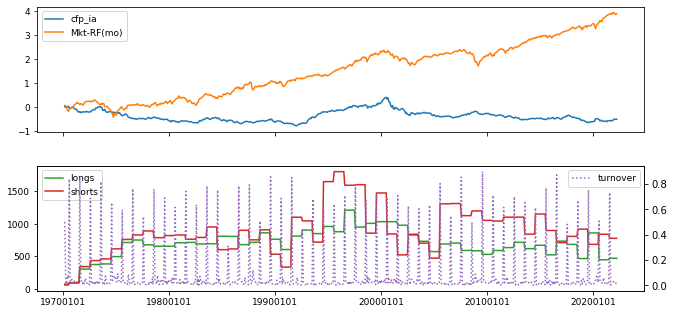

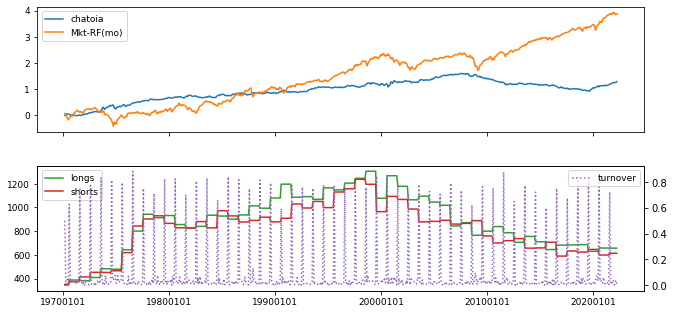

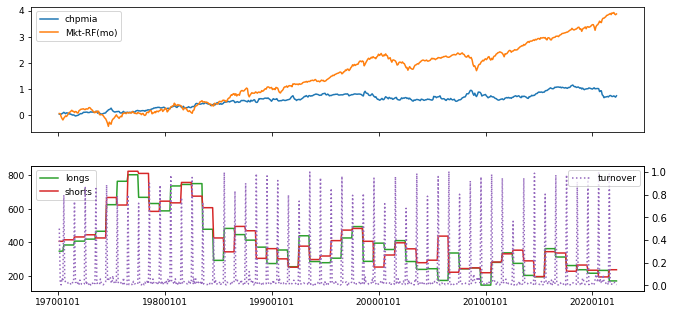

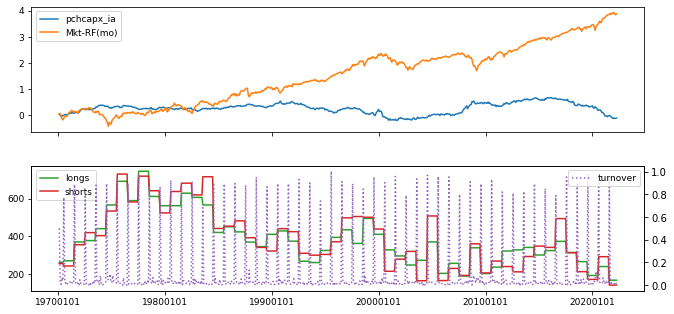

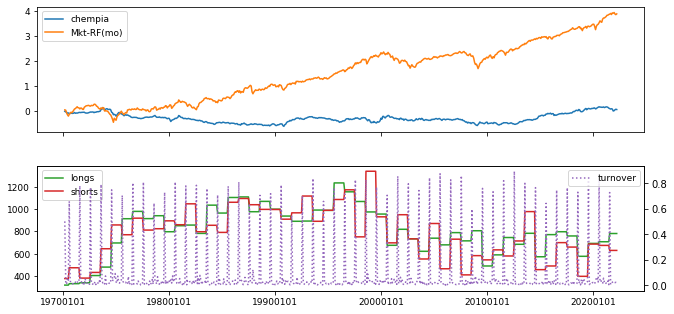

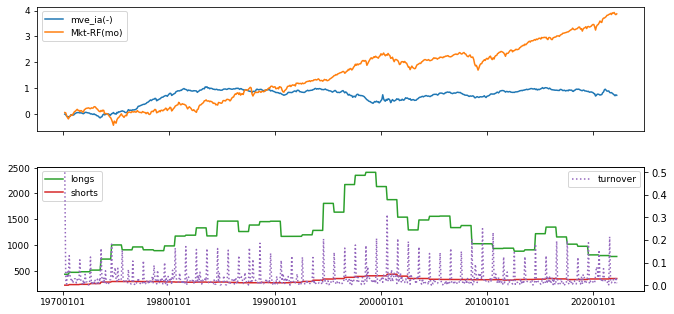

In [6]:
if 'pstann' in testable:
    columns = ['absacc', 'acc', 'agr', 'bm', 'cashpr', 'cfp', 'chcsho',
               'chinv', 'depr', 'dy', 'egr', 'ep', 'gma', 'grcapx',
               'grltnoa', 'hire', 'invest', 'lev', 'lgr' ,
               'pchdepr', 'pchgm_pchsale', 'pchquick',
               'pchsale_pchinvt', 'pchsale_pchrect', 'pchsale_pchxsga',
               'pchsaleinv', 'pctacc', 'quick', 'rd_sale', 'rd_mve',
               'realestate', 'salecash', 'salerec', 'saleinv', 'secured',
               'sgr', 'sp', 'tang', 'bm_ia', 'cfp_ia', 'chatoia' , 'chpmia',
               'pchcapx_ia', 'chempia', 'mve_ia']
    numlag = 6       # number of months to lag data for rebalance
    end = LAST_DATE   # last data date

    if regenerate:
        # retrieve annual, keep [permno, datadate] with non null prccq if any
        fields = ['sic', 'fyear', 'ib', 'oancf', 'at', 'act', 'che', 'lct',
                  'dlc', 'dltt', 'prcc_f', 'csho', 'invt', 'dp', 'ppent',
                  'dvt', 'ceq', 'txp', 'revt', 'cogs', 'rect', 'aco', 'intan',
                  'ao', 'ap', 'lco', 'lo', 'capx', 'emp', 'ppegt', 'lt',
                  'sale', 'xsga', 'xrd', 'fatb', 'fatl', 'dm']
        df = pstat.get_linked(
            dataset='annual',
            fields=fields,
            date_field='datadate',
            where=(f"indfmt = 'INDL' "
                   f"  AND datafmt = 'STD'"
                   f"  AND curcd = 'USD' "
                   f"  AND popsrc = 'D'"
                   f"  AND consol = 'C'"
                   f"  AND datadate <= {end//100}31"))
        fund = df.sort_values(['permno', 'datadate', 'ib'])\
                 .drop_duplicates(['permno', 'datadate'])\
                 .dropna(subset=['ib'])
        fund.index = list(zip(fund['permno'], fund['datadate']))  # multi-index
        fund['rebaldate'] = bd.endmo(fund.datadate, numlag)

        # precompute, and lag common metrics: mve_f avg_at sic2
        fund['sic2'] = np.where(fund['sic'].notna(),
                                fund['sic'] // 100, 0)
        fund['fyear'] = fund['datadate'] // 10000      # can delete this
        fund['mve_f'] = fund['prcc_f'] * fund['csho']
    
        lag = fund.shift(1, fill_value=0)
        lag.loc[lag['permno'] != fund['permno'], fields] = np.nan
        fund['avg_at'] = (fund['at'] + lag['at']) / 2
    
        lag2 = fund.shift(2, fill_value=0)
        lag2.loc[lag2['permno'] != fund['permno'], fields] = np.nan
        lag['avg_at'] = (lag['at'] + lag2['at']) / 2
    
        fund['bm'] = fund['ceq'] / fund['mve_f']
        fund['cashpr'] = (fund['mve_f'] + fund['dltt'] - fund['at'])/fund['che']
        fund['depr'] = fund['dp'] / fund['ppent']
        fund['dy'] = fund['dvt'] / fund['mve_f']
        fund['ep'] = fund['ib'] / fund['mve_f']
        fund['lev'] = fund['lt'] / fund['mve_f']
        fund['quick'] = (fund['act'] - fund['invt']) / fund['lct']
        fund['rd_sale'] = fund['xrd'] / fund['sale']
        fund['rd_mve'] = fund['xrd'] / fund['mve_f']
        fund['realestate'] = ((fund['fatb'] + fund['fatl']) /
                              np.where(fund['ppegt'].notna(),
                                       fund['ppegt'], fund['ppent']))
        fund['salecash'] = fund['sale'] / fund['che']
        fund['salerec'] = fund['sale'] / fund['rect']
        fund['saleinv'] = fund['sale'] / fund['invt']
        fund['secured'] = fund['dm'] / fund['dltt']
        fund['sp'] = fund['sale'] / fund['mve_f']
        fund['tang'] = (fund['che']
                        + fund['rect'] * 0.715
                        + fund['invt'] * 0.547
                        + fund['ppent'] * 0.535) / fund['at']

        # changes: agr chcsho chinv egr gma egr grcapx grltnoa emp invest lgr
        fund['agr'] = (fund['at'] / lag['at'])
        fund['chcsho'] = (fund['csho'] / lag['csho'])
        fund['chinv'] = ((fund['invt'] - lag['invt']) / fund['avg_at'])
        fund['egr'] = (fund['ceq'] / lag['ceq'])
        fund['gma'] = ((fund['revt'] - fund['cogs']) / lag['at'])
        fund['grcapx'] = (fund['capx'] / lag2['capx'])
        fund['grltnoa'] =  (((fund['rect']
                              + fund['invt']
                              + fund['ppent']
                              + fund['aco']
                              + fund['intan']
                              + fund['ao']
                              - fund['ap']
                              - fund['lco']
                              - fund['lo'])
                             / (lag['rect']
                                + lag['invt']
                                + lag['ppent']
                                + lag['aco']
                                + lag['intan']
                                + lag['ao']
                                - lag['ap']
                                - lag['lco']
                                - lag['lo']))
                            - ((fund['rect']
                                + fund['invt']
                                + fund['aco']
                                - fund['ap']
                                - fund['lco'])
                               - (lag['rect']
                                  + lag['invt']
                                  + lag['aco']
                                  - lag['ap']
                                  - lag['lco']))) / fund['avg_at']
        fund['hire'] = ((fund['emp'] / lag['emp']) - 1).fillna(0)
        fund['invest'] = (((fund['ppegt'] - lag['ppegt'])
                           + (fund['invt'] - lag['invt'])) / lag['at'])
        fund['invest'] = fund['invest']\
            .where(fund['invest'].notna(),
                   ((fund['ppent'] - lag['ppent'])
                    + (fund['invt'] - lag['invt'])) / lag['at'])
        fund['lgr'] = (fund['lt'] / lag['lt'])
        fund['pchdepr'] = ((fund['dp'] / fund['ppent'])
                           / (lag['dp'] / lag['ppent']))
        fund['pchgm_pchsale'] = (((fund['sale'] - fund['cogs'])
                                  / (lag['sale'] - lag['cogs']))
                                 - (fund['sale'] / lag['sale']))
        fund['pchquick'] = (((fund['act'] - fund['invt']) / fund['lct'])
                            / ((lag['act'] - lag['invt']) / lag['lct']))
        fund['pchsale_pchinvt'] = ((fund['sale'] / lag['sale'])
                                   - (fund['invt'] / lag['invt']))
        fund['pchsale_pchrect'] = ((fund['sale'] / lag['sale'])
                                   - (fund['rect'] / lag['rect']))
        fund['pchsale_pchxsga'] = ((fund['sale'] / lag['sale'])
                                   - (fund['xsga'] / lag['xsga']))
        fund['pchsaleinv'] = ((fund['sale'] / fund['invt'])
                              / (lag['sale'] / lag['invt']))
        fund['sgr'] = (fund['sale'] / lag['sale'])

        fund['chato'] = ((fund['sale'] / fund['avg_at'])
                         - (lag['sale'] / lag['avg_at']))
        fund['chpm'] = (fund['ib'] / fund['sale']) - (lag['ib'] / lag['sale'])
        fund['pchcapx'] = fund['capx'] / lag['capx']
    
        # compute signals with alternative definitions: acc absacc cfp
        fund['_acc'] = (((fund['act'] - lag['act'])
                         - (fund['che'] - lag['che']))
                        - ((fund['lct'] - lag['lct'])
                           - (fund['dlc'] - lag['dlc'])
                           - (fund['txp'] - lag['txp'])
                           - fund['dp']))
        fund['cfp'] = ((fund['ib'] - (((fund['act'] - lag['act'])
                                       - (fund['che'] - lag['che']))
                                      - ((fund['lct'] - lag['lct'])
                                         - (fund['dlc'] - lag['dlc'])
                                         - (fund['txp'] - lag['txp'])
                                         - fund['dp']))) / fund['mve_f'])
        g = fund['oancf'].notnull()
        fund.loc[g, 'cfp'] = fund.loc[g, 'oancf'] / fund.loc[g, 'mve_f']
        fund.loc[g, '_acc'] = fund.loc[g, 'ib'] - fund.loc[g, 'oancf']
        fund['acc'] = fund['_acc'] / fund['avg_at']
        fund['absacc'] = abs(fund['_acc']) / fund['avg_at']
        fund['pctacc'] = fund['_acc'] / abs(fund['ib'])
        h = (fund['ib'].abs() <= 0.01)
        fund.loc[h, 'pctacc'] = fund.loc[h, '_acc'] / 0.01

        # industry-adjusted
        cols = {'bm_ia': 'bm', 'cfp_ia': 'cfp', 'chatoia': 'chato',
                'chpmia': 'chpm', 'pchcapx_ia': 'pchcapx',
                'chempia': 'hire', 'mve_ia': 'mve_f'}
        group = fund.groupby(['sic2', 'fyear'])
        for k,v in cols.items():
            fund[k] = fund[v] - group[v].transform('mean')

        for label in columns:
            signals.write(fund, label, overwrite=True)

    rebalbeg, rebalend = 19700101, LAST_DATE
    benchnames = ['Mkt-RF(mo)'] #['Mom']  #['ST_Rev(mo)']   #
    for num, label in enumerate(columns):
        holdings = portfolio_sorts(crsp,
                                   label,
                                   SignalsFrame(signals.read(label)),
                                   rebalbeg,
                                   rebalend,
                                   window=12,
                                   months=[6],
                                   leverage=leverage.get(label, 1))
        excess = backtest_pipeline(backtest,
                                   crsp,
                                   holdings,
                                   label,
                                   benchnames,
                                   overlap=0,
                                   outdir=outdir,
                                   suffix=(leverage.get(label, 1) < 0)*'(-)')

## Fundamental signals from Compustat Quarterly

stdacc: 100%|█████████████████████████████████████████████████| 627/627 [00:07<00:00, 86.30it/s]


           excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
stdacc(-)   0.025   0.271   0.04      0.464    -0.06    0.953     0.619  327.353  776.179  0.614  0.624


stdcf: 100%|██████████████████████████████████████████████████| 627/627 [00:07<00:00, 88.83it/s]


          excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
stdcf(-)   0.031   0.326  0.049      0.544   -0.709    0.479     0.599  328.819  766.489  0.593  0.605


roavol: 100%|█████████████████████████████████████████████████| 627/627 [00:07<00:00, 80.30it/s]


        excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover     longs   shorts   buys  sells
roavol   0.005    0.04 -0.016     -0.134    0.388    0.698     0.628  1033.975  499.595  0.624  0.632


sgrvol: 100%|█████████████████████████████████████████████████| 627/627 [00:07<00:00, 81.75it/s]


        excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover   longs   shorts   buys  sells
sgrvol    0.02   0.145  0.001      0.007   -0.488    0.626      0.64  639.74  495.144  0.635  0.645


cinvest: 100%|████████████████████████████████████████████████| 627/627 [00:08<00:00, 75.58it/s]


            excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
cinvest(-)   0.014   0.191  0.015      0.208    -0.42    0.675     3.001  805.526  749.985  2.998  3.004


chtx: 100%|███████████████████████████████████████████████████| 627/627 [00:08<00:00, 73.09it/s]


      excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
chtx   0.027   0.287   0.02      0.218   -1.062    0.289     2.941  769.017  731.673  2.932   2.95


rsup: 100%|███████████████████████████████████████████████████| 627/627 [00:08<00:00, 71.72it/s]


      excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs  shorts   buys  sells
rsup   0.025   0.208  0.028      0.235    0.766    0.444     2.202  806.802  819.46  2.194  2.209


roaq: 100%|███████████████████████████████████████████████████| 627/627 [00:08<00:00, 72.32it/s]


      excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs    shorts  buys  sells
roaq   0.032   0.255   0.05      0.415    0.745    0.457     1.919  753.929  1381.109  1.91  1.927


cash: 100%|███████████████████████████████████████████████████| 627/627 [00:08<00:00, 70.09it/s]


      excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover     longs   shorts  buys  sells
cash   0.042   0.361  0.024      0.215   -0.047    0.962     1.354  1431.296  625.783  1.34  1.368


nincr: 100%|██████████████████████████████████████████████████| 627/627 [00:09<00:00, 67.75it/s]


       excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs    shorts   buys  sells
nincr    0.03   0.434  0.026      0.376   -0.508    0.612     3.146  477.315  1997.236  3.138  3.155


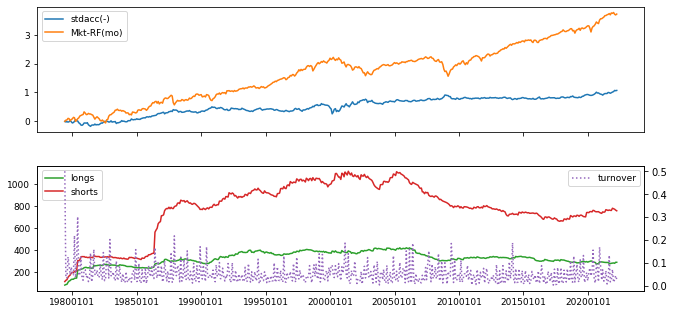

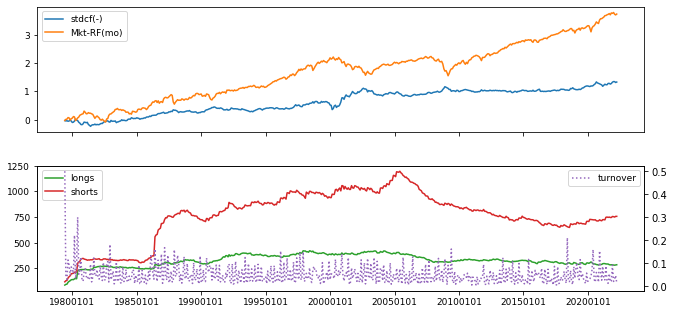

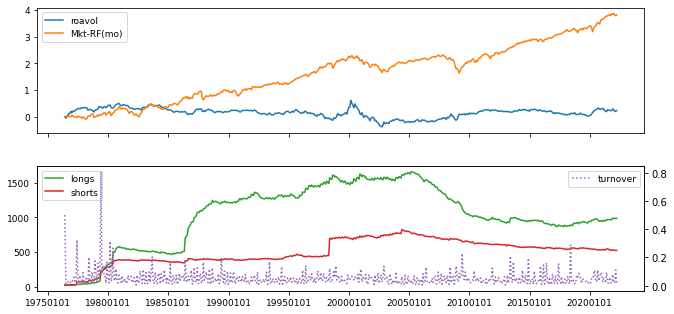

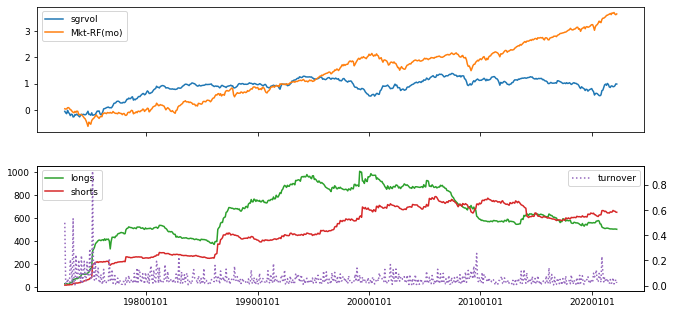

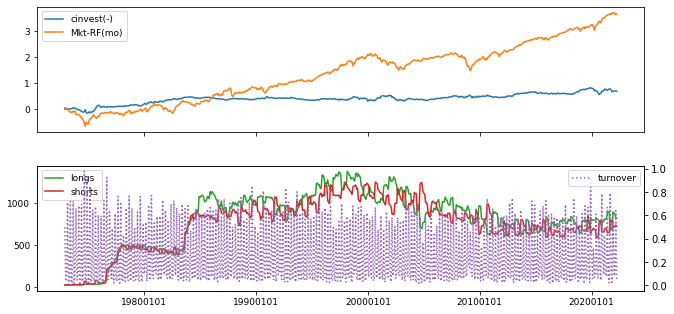

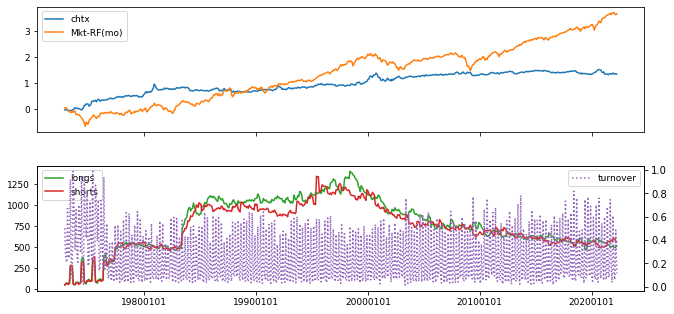

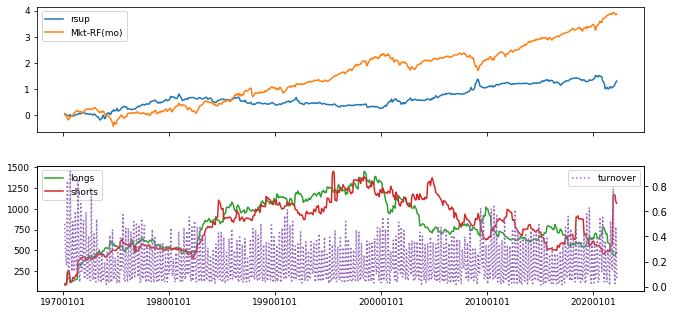

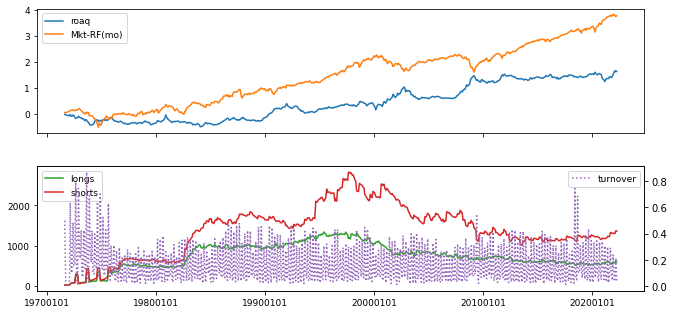

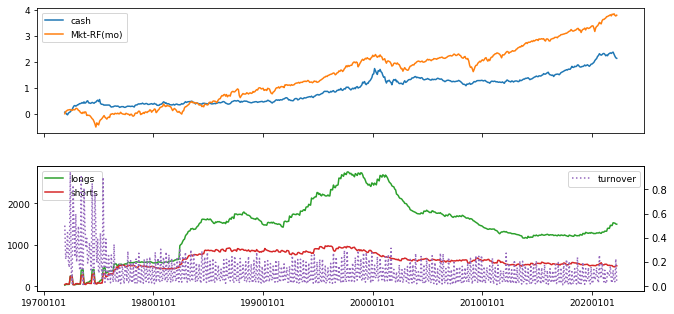

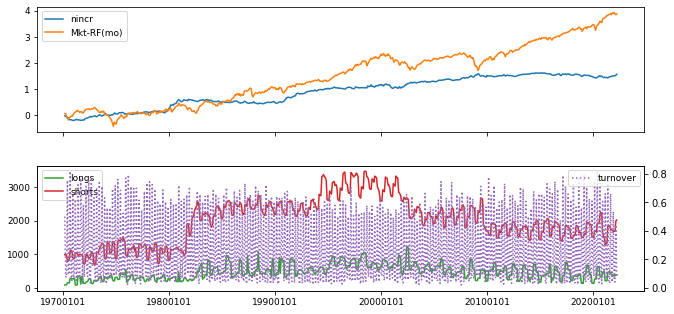

In [7]:
if 'pstqtr' in testable:
    columns = ['stdacc', 'stdcf', 'roavol', 'sgrvol', 'cinvest', 'chtx',
               'rsup', 'roaq', 'cash', 'nincr']
    numlag = 4       # require 4 month lag of fiscal data
    end = LAST_DATE

    if regenerate:
        # retrieve quarterly, keep [permno, datadate] key with non null prccq
        fields = ['ibq', 'actq', 'cheq', 'lctq', 'dlcq', 'saleq', 'prccq',
                  'cshoq', 'atq', 'txtq', 'ppentq']
        df = pstat.get_linked(dataset='quarterly',
                              fields=fields,
                              date_field='datadate',
                              where=(f"datadate > 0 "
                                     f"and datadate <= {end//100}31"))
        fund = df.sort_values(['permno','datadate', 'ibq'])\
                 .drop_duplicates(['permno', 'datadate'])\
                 .dropna(subset=['ibq'])
        fund.index = list(zip(fund['permno'], fund['datadate']))
        rebaldate = bd.endmo(fund.datadate, numlag)

        # compute current and lagged: scf sacc roaq nincr cinvest cash rsup chtx
        lag = fund.shift(1, fill_value=0)
        lag.loc[lag['permno'] != fund['permno'], fields] = np.nan
        fund['_saleq'] = fund['saleq']
        fund.loc[fund['_saleq'].lt(0.01), '_saleq'] = 0.01
        
        fund['sacc'] = (((fund['actq'] - lag['actq'])
                         - (fund['cheq'] - lag['cheq']))
                        - ((fund['lctq'] - lag['lctq'])
                           - (fund['dlcq'] - lag['dlcq']))) / fund['_saleq']
        fund['cinvest'] = (fund['ppentq'] - lag['ppentq']) / fund['_saleq']
        fund['nincr'] = (fund['ibq'] > lag['ibq']).astype(int)
        fund['scf']  = (fund['ibq'] / fund['_saleq']) - fund['sacc']
        fund['roaq'] = (fund['ibq'] / lag['atq'])
        fund['cash'] = (fund['cheq'] / fund['atq'])
        
        lag4 = fund.shift(4, fill_value=0)
        lag4.loc[lag4['permno'] != fund['permno'], fields] = np.nan
        fund['rsup'] = ((fund['saleq'] - lag4['saleq'])
                        / (fund['prccq'].abs() * fund['cshoq'].abs()))
        fund['chtx'] = (fund['txtq'] - lag4['txtq']) / lag4['atq']

        # for each var: make dataframe of 15 lags (column names=[0,...,15])
        lags = {col : as_lags(fund, var=col, key='permno', nlags=16)
                for col in ['sacc', 'scf', 'roaq', 'rsup', 'cinvest', 'nincr']}
        for i in range(1, 16):                      # lags[ninrc][i]=1 iff ibq
            lags['nincr'][i] *= lags['nincr'][i-1]  # increasing all prior qtrs

        # compute signals from the 15 lags
        fund['rebaldate'] = rebaldate
        fund['stdacc'] = lags['sacc'].std(axis=1, skipna=False)
        fund['stdcf'] = lags['scf'].std(axis=1, skipna=False)
        fund['roavol'] = lags['roaq'].std(axis=1, skipna=False)
        fund['sgrvol'] = lags['rsup'].std(axis=1, skipna=False)
        fund['cinvest'] = (fund['cinvest'] -
                           lags['cinvest'][[1, 2, 3, 4]].mean(axis=1,
                                                              skipna=False))

        # count number of consecutive increasing quarters
        fund['nincr'] = lags['nincr'][np.arange(8)].sum(axis=1)

        for label in columns:
            signals.write(fund, label, overwrite=True)

    rebalbeg, rebalend = 19700101, LAST_DATE
    benchnames = ['Mkt-RF(mo)']
    for num, label in enumerate(columns):
        holdings = portfolio_sorts(crsp,
                                   label,
                                   SignalsFrame(signals.read(label)),
                                   rebalbeg,
                                   rebalend,
                                   window=3,
                                   months=[],
                                   leverage=leverage.get(label, 1))
        excess = backtest_pipeline(backtest,
                                   crsp,
                                   holdings,
                                   label,
                                   benchnames,
                                   overlap=0,
                                   outdir=outdir,
                                   suffix='(-)'*(leverage.get(label, 1) < 0))

## IBES Fiscal Year 1 signals: chfeps, chnanalyst, disp

chfeps: 100%|█████████████████████████████████████████████████| 555/555 [00:09<00:00, 59.92it/s]


        excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
chfeps   0.043   0.484  0.048      0.544   -1.611    0.108     7.854  490.998  727.363  7.842  7.866


chnanalyst: 100%|█████████████████████████████████████████████| 555/555 [00:09<00:00, 60.17it/s]


            excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs  shorts   buys  sells
chnanalyst   0.003   0.052 -0.001     -0.022    0.089    0.929      5.77  278.566  827.88  5.769  5.771


disp: 100%|███████████████████████████████████████████████████| 555/555 [00:08<00:00, 62.92it/s]


         excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
disp(-)   0.037   0.238  0.079       0.59   -0.414    0.679     2.687  482.982  645.204  2.679  2.695


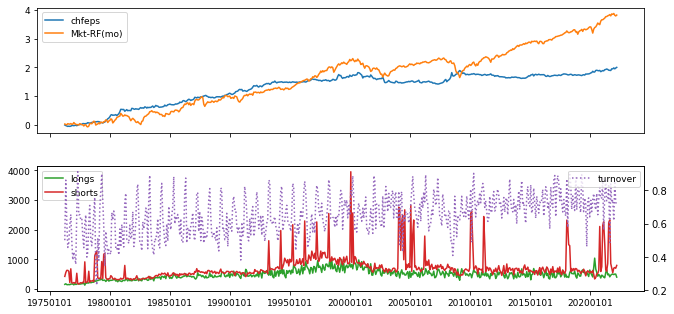

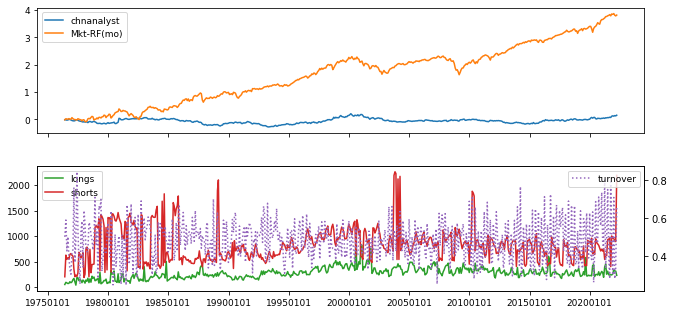

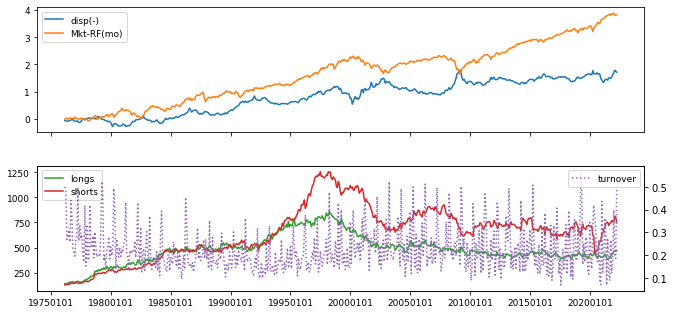

In [8]:
if 'ibesf1' in testable:
    columns = ['chfeps', 'chnanalyst', 'disp']

    if regenerate:
        df = ibes.get_linked(dataset='summary',
                             fields=['fpedats', 'meanest', 'medest',
                                     'stdev', 'numest'],
                             date_field = 'statpers',
                             where=("meanest IS NOT NULL "
                                    "  AND fpedats IS NOT NULL "
                                    "  AND statpers IS NOT NULL"
                                    "  AND fpi = '1'"))
        out = df.sort_values(['permno', 'statpers', 'fpedats', 'meanest'])\
                .drop_duplicates(['permno', 'statpers', 'fpedats'])
        out['rebaldate'] = bd.endmo(out['statpers'])

        out['disp'] = out['stdev'] / abs(out['meanest'])
        out.loc[abs(out['meanest']) < 0, 'disp'] = out['stdev'] / 0.01
    
        lag1 = out.shift(1, fill_value=0)
        f1 = (lag1['permno'] == out['permno'])        
        out.loc[f1, 'chfeps'] = out.loc[f1, 'meanest'] - lag1.loc[f1, 'meanest']

        lag3 = out.shift(3, fill_value=0)
        f3 = (lag3['permno'] == out['permno'])
        out.loc[f3, 'chnanalyst'] = out.loc[f3, 'numest']-lag3.loc[f3, 'numest']

        for label in columns:
            signals.write(out, label, overwrite=True)

    rebalbeg, rebalend = 19760101, LAST_DATE
    benchnames = ['Mkt-RF(mo)']
    for num, label in enumerate(columns):
        holdings = portfolio_sorts(crsp,
                                   label,
                                   SignalsFrame(signals.read(label)),
                                   rebalbeg,
                                   rebalend,
                                   window=3,
                                   months=[],
                                   leverage=leverage.get(label, 1))
        excess = backtest_pipeline(backtest,
                                   crsp,
                                   holdings,
                                   label,
                                   benchnames,
                                   overlap=0,
                                   outdir=outdir,
                                   suffix=(leverage.get(label, 1) < 0)*'(-)')

## IBES Long-term Growth signals: fgr5yr

fgr5yr: 100%|█████████████████████████████████████████████████| 555/555 [00:08<00:00, 69.19it/s]


        excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
fgr5yr  -0.001  -0.006 -0.052     -0.346    0.457    0.648      1.21  869.526  350.828  1.201  1.219


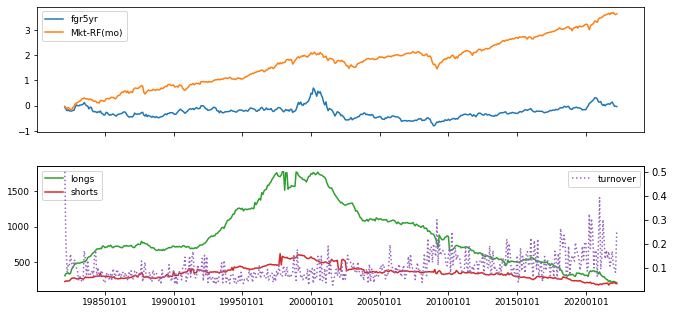

In [9]:
if 'ibesltg' in testable:
    columns = ['fgr5yr']

    if regenerate:
        df = ibes.get_linked(dataset='summary',
                             fields = ['meanest'],
                             date_field = 'statpers',
                             where=("meanest IS NOT NULL "
                                    "  AND fpi = '0'"
                                    "  AND statpers IS NOT NULL"))
        out = df.sort_values(['permno', 'statpers', 'meanest'])\
                .drop_duplicates(['permno', 'statpers'])\
                .dropna()
        out['rebaldate'] = bd.endmo(out['statpers'])
        out['fgr5yr'] = out['meanest']
        signals.write(out, 'fgr5yr', overwrite=True)

    rebalbeg, rebalend = 19760101, LAST_DATE
    benchnames = ['Mkt-RF(mo)']
    for num, label in enumerate(columns):
        holdings = portfolio_sorts(crsp,
                                   label,
                                   SignalsFrame(signals.read(label)),
                                   rebalbeg,
                                   rebalend,
                                   window=3,
                                   months=[],
                                   leverage=leverage.get(label, 1))
        excess = backtest_pipeline(backtest,
                                   crsp,
                                   holdings,
                                   label,
                                   benchnames,
                                   overlap=0,
                                   outdir=outdir,
                                   suffix=(leverage.get(label, 1) < 0)*'(-)')
    

## Announcement date (rdq) in Quarterly, linked to CRSP daily: ear, aeavol

ear: 100%|████████████████████████████████████████████████████| 627/627 [00:08<00:00, 71.30it/s]


     excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
ear   0.012   0.112  -0.01     -0.111    0.812    0.417     1.681  1083.34  617.679  1.675  1.687


aeavol: 100%|█████████████████████████████████████████████████| 627/627 [00:08<00:00, 74.61it/s]


           excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover     longs   shorts   buys  sells
aeavol(-)   0.027   0.265  0.037      0.376   -0.607    0.544     1.746  1540.441  373.752  1.737  1.754


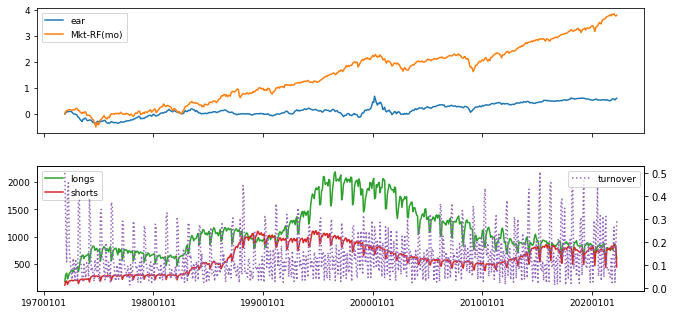

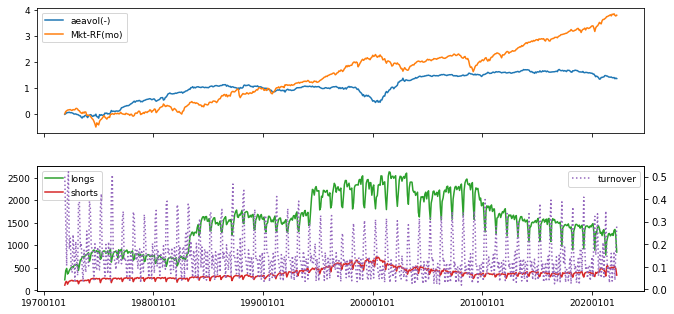

In [10]:
if 'rdq_daily' in testable:
    columns = ['ear', 'aeavol']

    if regenerate:
        # retrieve rdq, and set rebalance date to at least one month delay
        df = pstat.get_linked(dataset='quarterly',
                              fields=['rdq'],
                              date_field='datadate',
                              where=('rdq > 0'))
        fund = df.sort_values(['permno', 'rdq', 'datadate'])\
                 .drop_duplicates(['permno', 'rdq'])\
                 .dropna()
        fund['rebaldate'] = bd.offset(fund['rdq'], 2)

        # ear is compounded return around 3-day window
        out = crsp.get_window(dataset='daily',
                              field='ret',
                              date_field='date',
                              permnos=fund['permno'],
                              dates=fund['rdq'],
                              left=-1,
                              right=1)
        fund['ear'] = (1 + out).prod(axis = 1).values

                              
        # aeavol is avg volume in 3-day window to 20-day average ten-days prior
        actual = crsp.get_window(dataset='daily',
                                 field='vol',
                                 date_field='date',
                                 permnos=fund['permno'],
                                 dates=fund['rdq'],
                                 left=-1,
                                 right=1)
        normal = crsp.get_window(dataset='daily',
                                 field='vol',
                                 date_field='date',
                                 permnos=fund['permno'],
                                 dates=fund['rdq'],
                                 left=-30,
                                 right=-11,
                                 avg=True)
        fund['aeavol'] = normal['vol'].values
    
        signals.write(fund, 'ear', overwrite=True)
        signals.write(fund, 'aeavol', overwrite=True)

    rebalbeg, rebalend = 19700101, LAST_DATE
    benchnames = ['Mkt-RF(mo)']
    for num, label in enumerate(columns):
        holdings = portfolio_sorts(crsp,
                                   label,
                                   SignalsFrame(signals.read(label)),
                                   rebalbeg,
                                   rebalend,
                                   window=3,
                                   months=[],
                                   leverage=leverage.get(label, 1))
        excess = backtest_pipeline(backtest,
                                   crsp,
                                   holdings,
                                   label,
                                   benchnames,
                                   overlap=0,
                                   outdir=outdir,
                                   suffix=(leverage.get(label, 1) < 0)*'(-)')

## IBES Fiscal Year 1 linked to Quarterly PSTAT: sfeq

sfeq: 100%|███████████████████████████████████████████████████| 555/555 [00:09<00:00, 61.13it/s]


      excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
sfeq  -0.191  -1.533 -0.184     -1.484   -0.791    0.429      1.19  541.641  924.913  1.242  1.137


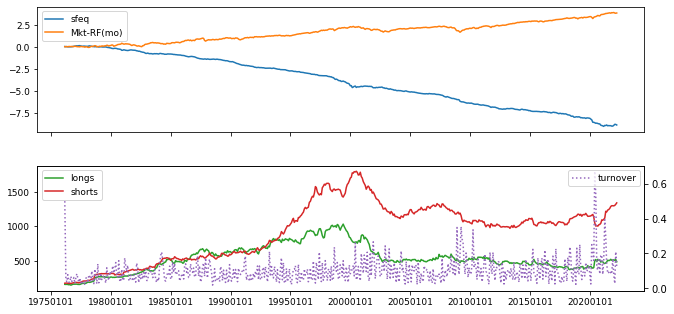

In [11]:
if 'ibesf1_pstqtr' in testable:
    beg, end = 19760101, LAST_DATE
    monthnum = lambda d: ((d//10000)-1900)*12 + ((d//100)%100) - 1
    if regenerate:
        df = pstat.get_linked(dataset='quarterly',
                              fields=['prccq'],
                              date_field='datadate')
        df = df.dropna()\
               .sort_values(['permno', 'datadate'])\
               .drop_duplicates(['permno', 'datadate'])
        
        out = ibes.get_linked(dataset='summary',
                              fields=['fpedats', 'meanest'],
                              date_field='statpers',
                              where="fpi='1'")
        out = out.dropna()\
                 .sort_values(['permno', 'statpers', 'fpedats'])\
                 .drop_duplicates(['permno', 'statpers'])
        out['monthnum'] = monthnum(out['statpers'])
        out = out.set_index(['permno', 'monthnum'], drop=False)
        out['sfeq'] = np.nan

        for num in range(4): # match ibes statpers to any datadate in last 4 mos
            df['monthnum'] = monthnum(df['datadate']) - num
            df = df.set_index(['permno', 'monthnum'], drop=False)
            out = out.join(df[['prccq']], how='left')
            out['sfeq'] = out['sfeq'].where(out['sfeq'].notna(),
                                          out['meanest'] / out['prccq'].abs())
            out = out.drop(columns=['prccq'])

        out['rebaldate'] = bd.endmo(out['statpers'])
        n = signals.write(out.reset_index(drop=True), 'sfeq', overwrite=True)
        
    rebalbeg, rebalend = 19760101, LAST_DATE
    benchnames = ['Mkt-RF(mo)']
    label = 'sfeq'
    holdings = portfolio_sorts(crsp,
                               label,
                               SignalsFrame(signals.read(label)),
                               rebalbeg,
                               rebalend,
                               window=3,
                               months=[],
                               leverage=leverage.get(label, 1))
    excess = backtest_pipeline(backtest,
                               crsp,
                               holdings,
                               label,
                               benchnames,
                               overlap=0,
                               outdir=outdir, 
                               suffix=(leverage.get(label, 1) < 0)*'(-)')

## IBES Fiscal Year 1 linked to IBES price history: sfe

sfe: 100%|████████████████████████████████████████████████████| 555/555 [00:08<00:00, 62.12it/s]


     excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover    longs   shorts   buys  sells
sfe   0.043   0.292  0.068      0.494   -0.986    0.324     1.771  546.812  999.632  1.767  1.775


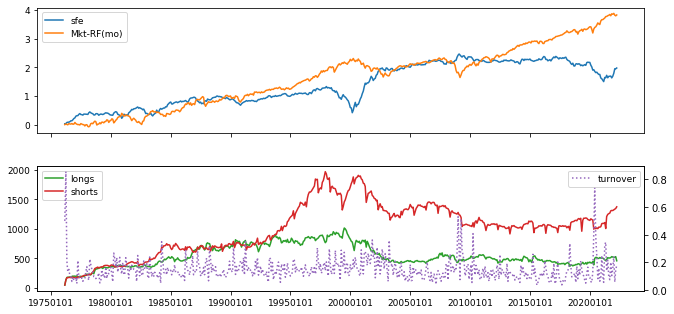

In [12]:
if 'ibesf1_hist' in testable:
    beg, end = 19760101, LAST_DATE
    if regenerate:
        # retrieve monthly price history
        df = ibes.get_linked(dataset='history',
                             fields=['price'],
                             date_field='statpers')
        hist = df.dropna()\
                 .sort_values(['permno', 'statpers'])\
                 .drop_duplicates(['permno', 'statpers'], keep='last')\
                 .set_index(['permno', 'statpers'])

        # retrieve monthly FY1 mean estimate
        df = ibes.get_linked(dataset='summary',
                             fields=['fpedats', 'meanest'],
                             date_field='statpers',
                             where="fpi='1' AND statpers <= fpedats")
        out = df.dropna()\
                .sort_values(['permno', 'statpers', 'fpedats'])\
                .drop_duplicates(['permno', 'statpers'])\
                .set_index(['permno', 'statpers'])

        # join on [permno, statpers], and reindex on [permno, rebaldate]
        out = out.join(hist[['price']], how='left').reset_index()
        out['rebaldate'] = bd.endmo(out['statpers'])
        out = out.set_index(['permno', 'rebaldate'])
        out['sfe'] = out['meanest'].div(out['price'].abs())
        n = signals.write(out.reset_index(), 'sfe', overwrite=True)
        
    rebalbeg, rebalend = 19760101, LAST_DATE
    benchnames = ['Mkt-RF(mo)']
    label = 'sfe'
    holdings = portfolio_sorts(crsp,
                               label,
                               SignalsFrame(signals.read(label)),
                               rebalbeg,
                               rebalend,
                               window=3,
                               months=[],
                               leverage=leverage.get(label, 1))
    excess = backtest_pipeline(backtest,
                               crsp,
                               holdings,
                               label,
                               benchnames,
                               overlap=0,
                               outdir=outdir, 
                               suffix=(leverage.get(label, 1) < 0)*'(-)')
    

## IBES Fiscal Quarter 1, linked to Quarterly: sue

sue: 100%|████████████████████████████████████████████████████| 555/555 [00:07<00:00, 71.13it/s]


     excess  sharpe  alpha  appraisal  welch-t  welch-p  turnover     longs   shorts   buys  sells
sue   0.043   0.484  0.044      0.489    0.508    0.612     3.024  1479.944  704.749  3.012  3.035


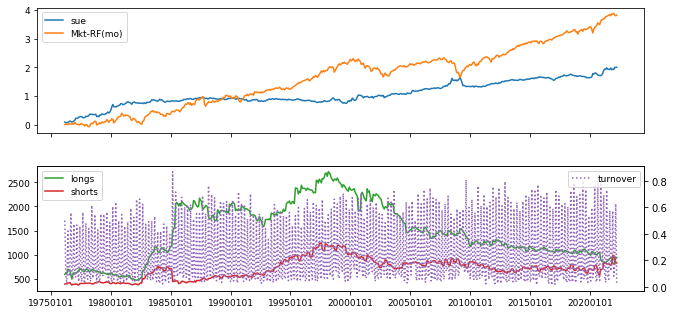

In [13]:
if 'ibesq1_pstqtr' in testable:
    columns = ['sue']
    numlag = 4
    end = LAST_DATE

    if regenerate:
        # retrieve quarterly, keep [permno, datadate] key with non null prccq
        df = pstat.get_linked(dataset='quarterly',
                              fields=['prccq', 'cshoq', 'ibq'],
                              date_field='datadate',
                              where=f"datadate <= {end//100}31")
        fund = df.dropna(subset=['ibq'])\
                 .sort_values(['permno', 'datadate', 'cshoq'])\
                 .drop_duplicates(['permno', 'datadate'])
        fund['rebaldate'] = bd.endmo(fund['datadate'], numlag)
        fund = fund.set_index(['permno', 'rebaldate'], drop=False)

        # retrieve ibes Q1 where forecast period <= fiscal date, keep latest
        df = ibes.get_linked(dataset='summary',
                             fields=['fpedats', 'medest', 'actual'],
                             date_field='statpers',
                             where=" fpi = '6' AND statpers <= fpedats")
        summ = df.dropna()\
                 .sort_values(['permno', 'fpedats', 'statpers'])\
                 .drop_duplicates(['permno', 'fpedats'], keep='last')
        summ['rebaldate'] = bd.endmo(summ['fpedats'], numlag)
        summ = summ.set_index(['permno', 'statpers'])

        # retrieve ibes price, then left join
        df = ibes.get_linked(dataset='history',
                             fields=['price'],
                             date_field='statpers')
        hist = df.dropna()\
                 .sort_values(['permno', 'statpers'])\
                 .drop_duplicates(['permno', 'statpers'], keep='last')
        hist = hist.set_index(['permno', 'statpers'])
        summ = summ.join(hist[['price']], how='left')
        summ = summ.reset_index()\
                   .set_index(['permno', 'rebaldate'])\
                   .reindex(fund.index)

        # sue with ibes surprise and price
        fund['sue'] = (summ['actual'] - summ['medest']) / summ['price'].abs()

        # sue with ibes surprice and compustat quarterly price
        fund['sue'] = fund['sue']\
            .where(fund['sue'].notna(),
                   (summ['actual'] - summ['medest']) / fund['prccq'].abs())

        # sue with lag(4) difference in compustat quarterly and price
        lag = fund.shift(4, fill_value=0)
        fund['sue'] = fund['sue']\
            .where(fund['sue'].notna() | (lag['permno'] != fund['permno']),
                   ((fund['ibq'] - lag['ibq']) /
                    (fund['prccq'] * fund['cshoq'])).abs())

        signals.write(fund.reset_index(drop=True), 'sue', overwrite=True)

    rebalbeg, rebalend = 19760101, LAST_DATE
    benchnames = ['Mkt-RF(mo)']
    for num, label in enumerate(columns):
        holdings = portfolio_sorts(crsp,
                                   label,
                                   SignalsFrame(signals.read(label)),
                                   rebalbeg,
                                   rebalend,
                                   window=3,
                                   months=[],
                                   leverage=leverage.get(label, 1))
        excess = backtest_pipeline(backtest,
                                   crsp,
                                   holdings,
                                   label,
                                   benchnames,
                                   overlap=0,
                                   outdir=outdir,
                                   suffix=(leverage.get(label, 1) < 0)*'(-)')

## Summarize all results

In [42]:
# sorted by Welch's t-value to test for difference in pre- and post-2002 mean 
if 'summarize' in testable:
    zoo = backtest.read().sort_values(['begret', 'permno'])
    r = []
    for label in tqdm(zoo.index):
        perf = backtest.read(label)
        excess = {'ret': backtest.fit(['Mkt-RF(mo)'])}
        excess['annualized'] = backtest.annualized
        excess['dd'] = maximum_drawdown(backtest.perf['excess'])
        post = {'ret': backtest.fit(['Mkt-RF(mo)'],
                                    beg=20020101).copy()}
        post['annualized'] = backtest.annualized.copy()
        s = label + ('(-)' if leverage.get(label, 1) < 0 else '')
        r.append(DataFrame({
            'Start': excess['ret'].index[0],
            'Sharpe Ratio': excess['annualized']['sharpe'],
            'Alpha': excess['annualized']['alpha'],
            'Appraisal Ratio': excess['annualized']['appraisal'],
            'Avg Ret': excess['ret']['excess'].mean(),
            'Vol': excess['ret']['excess'].std(ddof=0),
            'Welch-t': excess['annualized']['welch-t'],
            'Appraisal2002': post['annualized']['appraisal'],
            'Ret2002': post['ret']['excess'].mean(),
            'Vol2002': post['ret']['excess'].std(ddof=0),            
            'Best' : excess['ret']['excess'].idxmax(),
            'BestRet' : excess['ret']['excess'].max(),
            'Worst' : excess['ret']['excess'].idxmin(),
            'WorstRet' : excess['ret']['excess'].min(),
            'Drawdown': (excess['dd'].iloc[1]/excess['dd'].iloc[0]) - 1,
            'Beg': excess['dd'].index[0],
            'End': excess['dd'].index[1],
            'Turn2002+': post['annualized']['sells']/12,
            'Long2002+': int(post['annualized']['longs']),
            'Short2002+': int(post['annualized']['shorts'])}, index=[s]))
    df = pd.concat(r, axis=0).round(4).sort_values('Welch-t')

100%|███████████████████████████████████████████████████████████| 83/83 [00:20<00:00,  4.09it/s]


In [43]:
    pd.set_option('display.max_rows', None)
    show(df, **SHOW)

Start  Sharpe Ratio   Alpha  Appraisal Ratio  Avg Ret  \
pchsale_pchrect  19700227        0.0345  0.0018           0.0260   0.0002   
invest(-)        19700227        0.2760  0.0332           0.3739   0.0021   
pchdepr          19700227        0.1431  0.0102           0.1461   0.0008   
absacc(-)        19700227        0.0817  0.0196           0.1849   0.0007   
ep               19700227        0.3201  0.0655           0.4936   0.0037   
chatoia          19700227        0.3349  0.0273           0.3773   0.0020   
bm_ia            19700227        0.1284  0.0075           0.0673   0.0012   
bm               19700227        0.2892  0.0355           0.2706   0.0032   
pchsale_pchxsga  19700227       -0.0539 -0.0034          -0.0419  -0.0004   
cashpr(-)        19700227        0.2717  0.0349           0.3378   0.0024   
lev              19700227        0.0790  0.0075           0.0560   0.0009   
chfeps           19760331        0.4843  0.0483           0.5442   0.0036   
ill(-)           19830729        0.2507  0.0474           0.3809   0.0027   
indmom           19270228        0.3263  0.0496           0.3487   0.0040   
dolvol           19830729        0.0994  0.0052           0.0484   0.0009   
chcsho(-)        19700227        0.5094  0.0581           0.7681   0.0035   
agr(-)           19700227        0.3694  0.0494           0.5382   0.0030   
mom12m           19270228        0.3793  0.1126           0.5750   0.0069   
pchsaleinv       19700227        0.4957  0.0347           0.5117   0.0028   
chmom            19270228        0.4311  0.0481           0.3428   0.0054   
divyld           19270228        0.0143  0.0464           0.3397   0.0002   
dy               19700227        0.0531  0.0483           0.3442   0.0007   
mom1m(-)         19260331        0.3151  0.0403           0.2532   0.0044   
pchsale_pchinvt  19700227        0.4194  0.0294           0.4365   0.0024   
mom36m(-)        19290228        0.2045  0.0185           0.1064   0.0032   
chinv(-)         19700227        0.4816  0.0517           0.6481   0.0034   
chtx             19721130        0.2867  0.0203           0.2179   0.0023   
sfe              19760227        0.2923  0.0683           0.4943   0.0036   
sp               19700227        0.3754  0.0392           0.3302   0.0037   
realestate       19850131        0.1217  0.0361           0.3106   0.0012   
sfeq             19760227       -1.5332 -0.1838          -1.4839  -0.0160   
cfp_ia           19700227       -0.1025 -0.0141          -0.1449  -0.0008   
maxret(-)        19830729        0.2117  0.1015           0.6670   0.0033   
stdcf(-)         19790531        0.3256  0.0488           0.5435   0.0026   
mom6m            19260831        0.1779  0.0666           0.3644   0.0030   
egr(-)           19700227        0.3600  0.0458           0.5375   0.0027   
aeavol(-)        19711130        0.2652  0.0371           0.3759   0.0022   
retvol(-)        19830729        0.1955  0.1176           0.6631   0.0036   
nincr            19700227        0.4336  0.0256           0.3758   0.0025   
sgrvol           19720831        0.1454  0.0009           0.0066   0.0016   
cinvest(-)       19721130        0.1914  0.0149           0.2083   0.0011   
disp(-)          19760227        0.2380  0.0793           0.5898   0.0031   
beta             19290731        0.0856 -0.0570          -0.3601   0.0019   
mve_ia(-)        19700227        0.1459  0.0035           0.0387   0.0011   
idiovol(-)       19290731       -0.0380  0.0364           0.2011  -0.0007   
chpmia           19700227        0.1365  0.0152           0.1484   0.0012   
cfp              19700227        0.2401  0.0423           0.3664   0.0024   
rd_mve           19700227        0.2048  0.0146           0.1045   0.0024   
salecash         19700227       -0.0839  0.0081           0.0902  -0.0007   
sgr              19700227       -0.1208 -0.0261          -0.2646  -0.0010   
pchquick         19700227        0.0328  0.0025           0.0401   0.0002   
stdacc(-)       